In [1]:
# for running in collab, sagemaker etc.
import sys
sys.path.insert(0, "/home/studio-lab-user/Generative_Models_for_CERN_Fast_Simulations/utils")

In [2]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

2023-03-17 16:26:44.402195: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-17 16:26:44.402264: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-17 16:26:44.402272: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from tensorflow.keras import layers
import pickle
import time
from numpy import load
from matplotlib import pyplot
import pickle
import argparse

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

from scipy.stats import wasserstein_distance
import pandas as pd
from utils import sum_channels_parallel
from sklearn.metrics import mean_absolute_error
from datetime import datetime

2.11.0


### Load and process data

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
import sklearn
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [5]:
data = pd.read_pickle('../data/data_proton_photonsum_70_2312.pkl')
print('Loaded: ',  data.shape, "max:", data.max())

# Data containing particle conditional data from particle having responses with proton photon sum in interval [70, 2312] without taking into consideration photon sums of neutron responses.
data_cond = pd.read_pickle('../data/data_cond_photonsum_70_2312_0_3360.pkl')
print('Loaded cond: ',  data_cond.shape, "max:",data_cond.values.max(), "min:",data_cond.values.min())

Loaded:  (40853, 56, 30) max: 765.0
Loaded cond:  (40853, 12) max: 7000.0 min: -7000.0


In [6]:
# calculate min max proton sum
photon_sum_proton_min, photon_sum_proton_max = data_cond.proton_photon_sum.min(), data_cond.proton_photon_sum.max()

In [7]:
data_cond.drop(columns=['proton_photon_sum', 'neutron_photon_sum', 'Pdg'], inplace=True)
data_cond.columns, len(data_cond.columns)

(Index(['Energy', 'Vx', 'Vy', 'Vz', 'Px', 'Py', 'Pz', 'mass', 'charge'], dtype='object'),
 9)

In [8]:
data_cond.head()

Energy   Vx   Vy   Vz        Px        Py        Pz        mass  charge
0  3961.550  0.0  0.0  0.0 -0.076487  0.179845  3961.550  938.272081     1.0
1  2778.400  0.0  0.0  0.0 -0.102053  0.152853  2778.400  938.272081     1.0
2  3195.120  0.0  0.0  0.0  0.560528 -0.149980  3195.110  938.272081     1.0
3   613.734  0.0  0.0  0.0  1.178260 -0.828276  -613.733  139.570610    -1.0
4  3045.430  0.0  0.0  0.0 -0.449678  0.101160  3045.430  938.272081     1.0

In [10]:
DATE_STR = datetime.now().strftime("%d_%m_%Y_%H_%M")

NAME = "vae"

EXPERIMENT_DIR_NAME = f"{NAME}_{int(photon_sum_proton_min)}_{int(photon_sum_proton_max)}_{DATE_STR}"

print("Experiment DIR: ", EXPERIMENT_DIR_NAME)

Experiment DIR:  vae_70_2312_17_03_2023_16_27


In [11]:
def create_dir(path):
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

In [12]:
def save_scales(model_name, scaler_means, scaler_scales):
    out_fnm = f"{model_name}_scales.txt"
    res = "#means"
    for mean_ in scaler_means:
        res += "\n" + str(mean_)
    res += "\n\n#scales"
    for scale_ in scaler_scales:
        res += "\n" + str(scale_)

    filepath = f"../models/{EXPERIMENT_DIR_NAME}/"
    create_dir(filepath)
    with open(filepath+out_fnm, mode="w") as f:
        f.write(res)

In [13]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

data max 6.641182 min 0.0


In [14]:
x_train, x_test, y_train, y_test, = train_test_split(data, data_cond, test_size=0.2, shuffle=False, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(32682, 56, 30) (8171, 56, 30) (32682, 9) (8171, 9)


In [15]:
scaler = StandardScaler()
# scale cond datascaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
print("cond max", y_train.max(), "min", y_train.min())

#save scales
save_scales("Proton", scaler.mean_, scaler.scale_)

cond max 8.428404193850309 min -8.021354467081776


In [16]:
# make tf datasets
dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size=128)
dataset_cond = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size=128)
dataset_with_cond = tf.data.Dataset.zip((dataset,dataset_cond)).shuffle(12800)

val_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size=128)
val_dataset_cond = tf.data.Dataset.from_tensor_slices(y_test).batch(batch_size=128)
val_dataset_with_cond = tf.data.Dataset.zip((val_dataset,val_dataset_cond)).shuffle(12800)

### Define Model

In [17]:
############################ Define Models ############################
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 10
cond_dim = 9
poz_dim = 6


############################ encoder ############################

input_img = Input(shape=[56,30,1],name='input_img')
input_cond = Input(shape=cond_dim,name='input_cond')
x = Conv2D(32, kernel_size=4, strides=2, padding='same')(input_img)
x = Conv2D(64, kernel_size=4, strides=2,padding='same')(x)
x = Conv2D(128, kernel_size=4, strides=2,padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Flatten()(x)
x = layers.concatenate([input_cond,x])
x = layers.Dense(latent_dim*2, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model([input_img, input_cond], [z_mean, z_log_var, z], name="encoder")
encoder.summary()
############################ decoder ############################


x = Input(shape=(latent_dim,))
cond = Input(shape=(cond_dim,))
inputs = Concatenate(axis=1)([x, cond])

g = Dense(7*4*128)(inputs)
g = Reshape((7,4,128))(g)

g = UpSampling2D()(g)
g = Conv2D(128, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

g = UpSampling2D()(g)
g = Conv2D(64, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

g = UpSampling2D()(g)
g = Conv2D(32, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

outputs = Conv2D(1, kernel_size=(1,3) ,activation='relu')(g)

generator = Model([x, cond], outputs, name='generator')
generator.summary()


# define losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
d_acc_r = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
d_acc_f = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
g_acc = keras.metrics.BinaryAccuracy(name="g_acc_g", threshold=0.5)

# define optimizer
vae_optimizer = tf.keras.optimizers.RMSprop(1e-4)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 56, 30, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 15, 32)   544         ['input_img[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 8, 64)    32832       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 7, 4, 128)    131200      ['conv2d_1[0][0]']               
                                                                                            

In [18]:
#trainin params

EPOCHS = 100
noise_dim = 10
num_examples_to_generate = 16


START_GENERATING_IMG_FROM_IDX = 20
# Seed to reuse for generating samples for comparison during training
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_cond = y_test[START_GENERATING_IMG_FROM_IDX:START_GENERATING_IMG_FROM_IDX+num_examples_to_generate]

### function to calculate ws distance between orginal and generated channels
org=np.exp(x_test)-1
ch_org = org.reshape(-1, 56,30)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values
del org

In [19]:
def calculate_ws_ch(n_calc):
    ws= [0,0,0,0,0]
    for j in range(n_calc):
        z = np.random.normal(0,1,(x_test.shape[0],10))
        z_c = y_test
        results = generator.predict([z,z_c])
        results = np.exp(results)-1
        try:
            ch_gen = np.array(results).reshape(-1,56,30)
            ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
            for i in range(5):
                ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
            ws = np.array(ws)
        except ValueError as e:
            print(e)

    ws = ws/n_calc
    print("ws mean",f'{ws.sum()/5:.2f}', end=" ")
    for n, score in enumerate(ws):
        print("ch"+str(n+1),f'{score:.2f}',end=" ")



####################### training ##############################
@tf.function
def train_step(batch,step):

    images, cond = batch
    step=step
    BATCH_SIZE = tf.shape(images)[0]

    #train vae
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = encoder([images, cond])
        reconstruction = generator([z, cond])
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mean_squared_error(tf.reshape(images,(-1,56,30,1)), reconstruction), axis=(1, 2)
            )
        )
        # kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        # kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        # total_loss = 0.7 * kl_loss + reconstruction_loss  
        total_loss = reconstruction_loss
        kl_loss = 0
    grads = tape.gradient(total_loss, generator.trainable_weights+encoder.trainable_weights)
    vae_optimizer.apply_gradients(zip(grads, generator.trainable_weights+encoder.trainable_weights))
    
    return total_loss, reconstruction_loss, kl_loss

In [21]:
filepath_mod = f"../models/{EXPERIMENT_DIR_NAME}/"
create_dir(filepath_mod)

history = []
history_loss = []
def train(dataset, epochs):
    tf_step = tf.Variable(0, dtype=float)
    step=0
    generate_and_save_images(generator,
                             epochs,
                             [seed, seed_cond])
    #print(calculate_ws_mae(3))
    for epoch in range(epochs):
        start = time.time()

        for batch in dataset:
            total_loss, reconstruction_loss, kl_loss =train_step(batch,tf_step)
            history.append([total_loss, reconstruction_loss, kl_loss])
            tf_step.assign_add(1)
            step = step+1

            if step%100==0:
                print("%d [Total loss: %.2f] [Recon_loss: %.2f] [KL loss: %.2f]"% (
                    step, total_loss, reconstruction_loss, kl_loss))

            if step%1000==0:
                generate_and_save_images(generator,
                               epoch,
                               [seed, seed_cond])

        generate_and_save_images(generator,
                                 epoch + 1,
                                 [seed, seed_cond]
                                 )

        # Save the model every epoch
        encoder.compile()
        generator.compile()
        encoder.save(os.path.join(filepath_mod, "enc_"+NAME + "_"+ str(epoch) +".h5"))
        generator.save(os.path.join(filepath_mod, "gen_"+NAME + "_"+ str(epoch) +".h5"))
        np.savez(os.path.join(filepath_mod, "history_"+NAME+".npz"),
                 np.array(history))
        calculate_ws_ch(min(epoch//5+1, 5))

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    return history


filepath_img = f"../images/{EXPERIMENT_DIR_NAME}/"
create_dir(filepath_img)

In [22]:
def generate_and_save_images(model, epoch, test_input):

    SUPTITLE_TXT = f"\nModel: VAE proton data" \
               f"\nPhotonsum interval: [{photon_sum_proton_min}, {photon_sum_proton_max}]" \
               f"\nEPOCH: {epoch}"
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)  # returns 16 responses
    fig, axs = plt.subplots(2, 7, figsize=(15, 5))
    fig.suptitle(SUPTITLE_TXT, x=0.1, horizontalalignment='left')

    for i in range(0, 14):
        if i < 7:
            x = x_test[START_GENERATING_IMG_FROM_IDX+i].reshape(56, 30)
        else:
            x = predictions[i-7].numpy().reshape(56, 30)
        #x[x<=0]=x.max()*-0.1
        im = axs[i // 7, i % 7].imshow(x, cmap='gnuplot')
        axs[i // 7, i % 7].axis('off')
        fig.colorbar(im, ax=axs[i // 7, i % 7])

    fig.tight_layout(rect=[0, 0, 1, 0.975])
    plt.savefig(os.path.join(filepath_img, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

### Train model

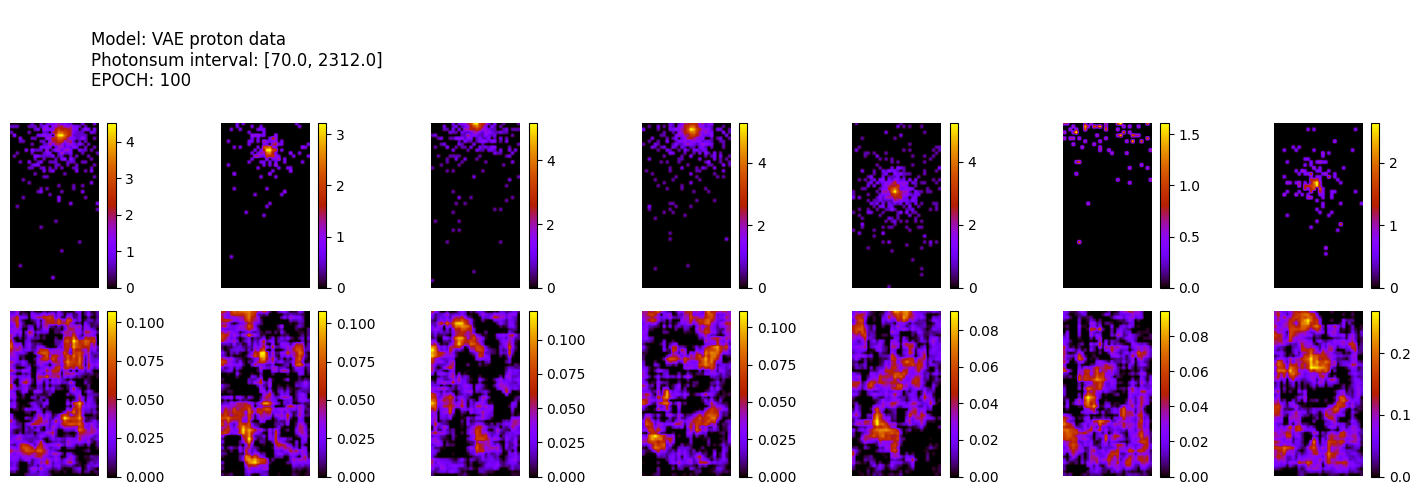

100 [Total loss: 107.48] [Recon_loss: 107.48] [KL loss: 0.00]
200 [Total loss: 103.72] [Recon_loss: 103.72] [KL loss: 0.00]


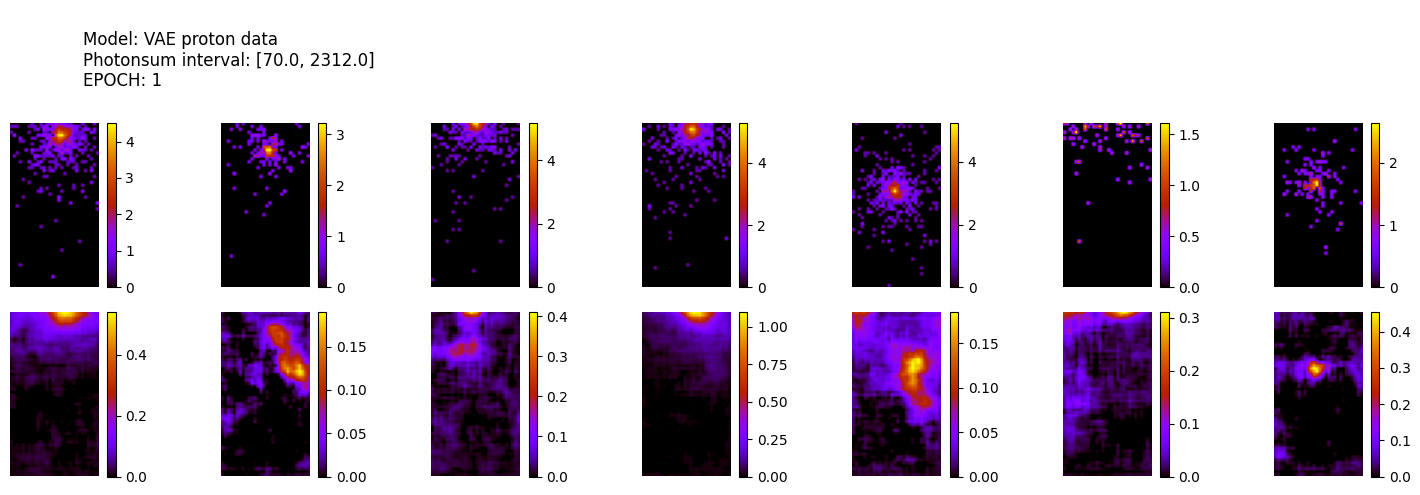

256/256 [==============================] - 1s 4ms/step
ws mean 117.55 ch1 0.16 ch2 98.83 ch3 0.74 ch4 194.62 ch5 293.41 Time for epoch 1 is 20.675699472427368 sec
300 [Total loss: 97.84] [Recon_loss: 97.84] [KL loss: 0.00]
400 [Total loss: 102.81] [Recon_loss: 102.81] [KL loss: 0.00]
500 [Total loss: 97.38] [Recon_loss: 97.38] [KL loss: 0.00]


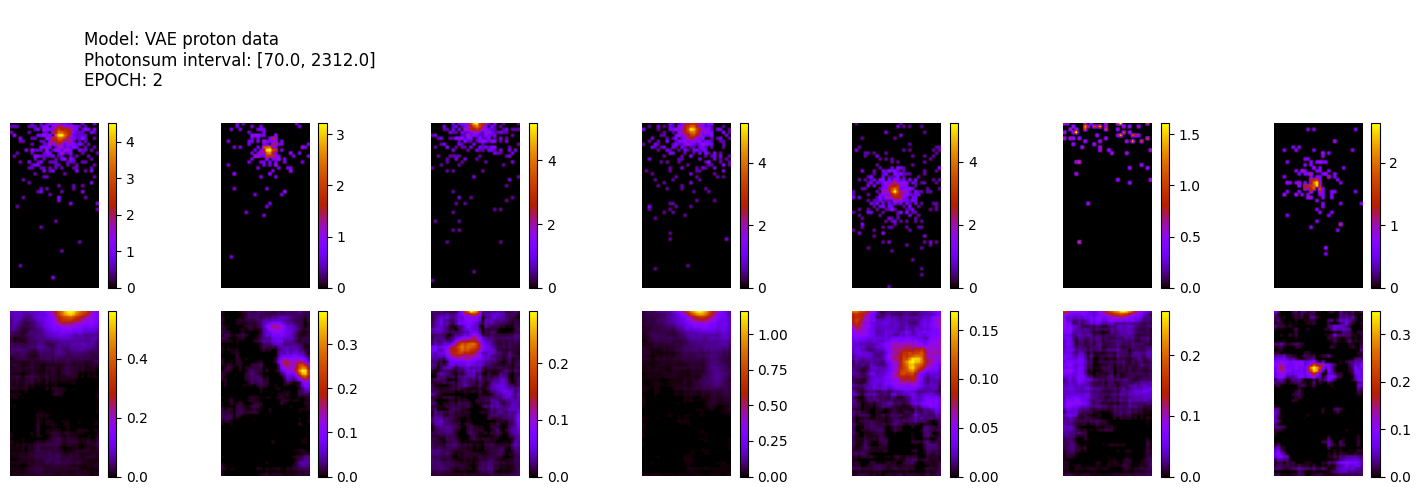

256/256 [==============================] - 1s 4ms/step
ws mean 118.78 ch1 0.16 ch2 99.45 ch3 0.75 ch4 196.93 ch5 296.60 Time for epoch 2 is 15.129905462265015 sec
600 [Total loss: 100.17] [Recon_loss: 100.17] [KL loss: 0.00]
700 [Total loss: 91.09] [Recon_loss: 91.09] [KL loss: 0.00]


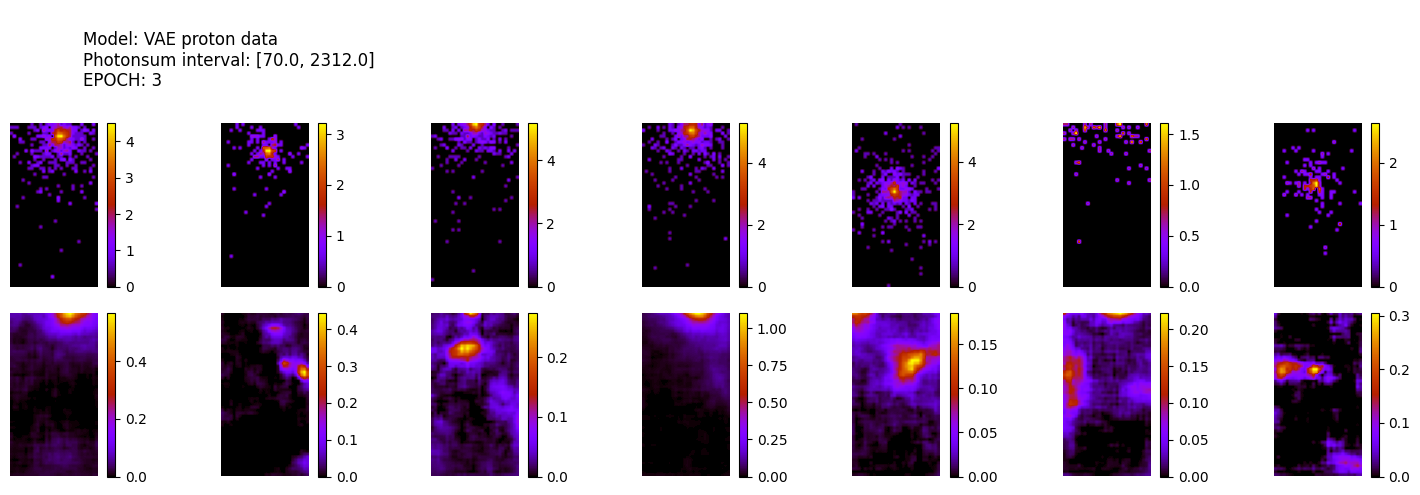

256/256 [==============================] - 1s 4ms/step
ws mean 118.73 ch1 0.16 ch2 98.11 ch3 0.76 ch4 198.11 ch5 296.51 Time for epoch 3 is 15.093456268310547 sec
800 [Total loss: 98.60] [Recon_loss: 98.60] [KL loss: 0.00]
900 [Total loss: 101.01] [Recon_loss: 101.01] [KL loss: 0.00]
1000 [Total loss: 94.85] [Recon_loss: 94.85] [KL loss: 0.00]


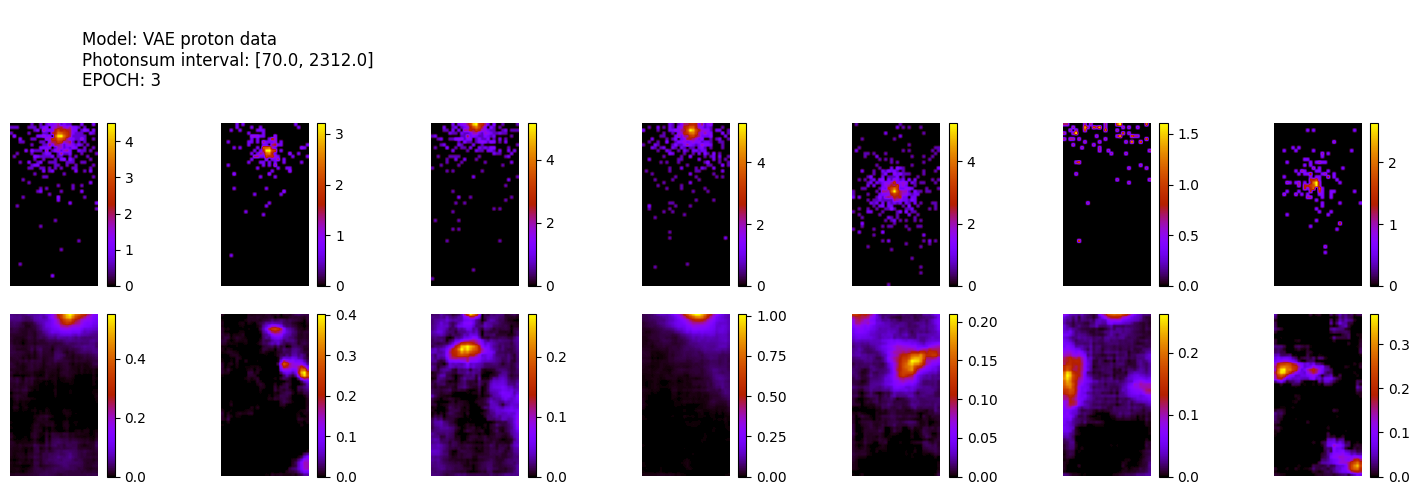

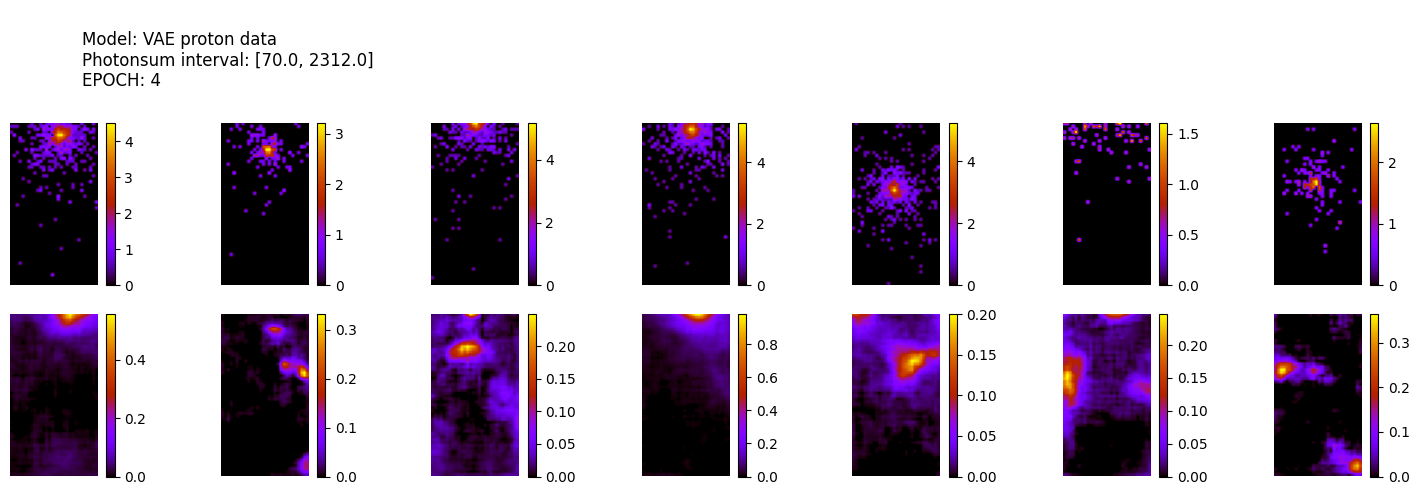

256/256 [==============================] - 1s 4ms/step
ws mean 120.50 ch1 0.17 ch2 100.64 ch3 0.77 ch4 199.91 ch5 301.02 Time for epoch 4 is 16.93321943283081 sec
1100 [Total loss: 94.52] [Recon_loss: 94.52] [KL loss: 0.00]
1200 [Total loss: 97.20] [Recon_loss: 97.20] [KL loss: 0.00]


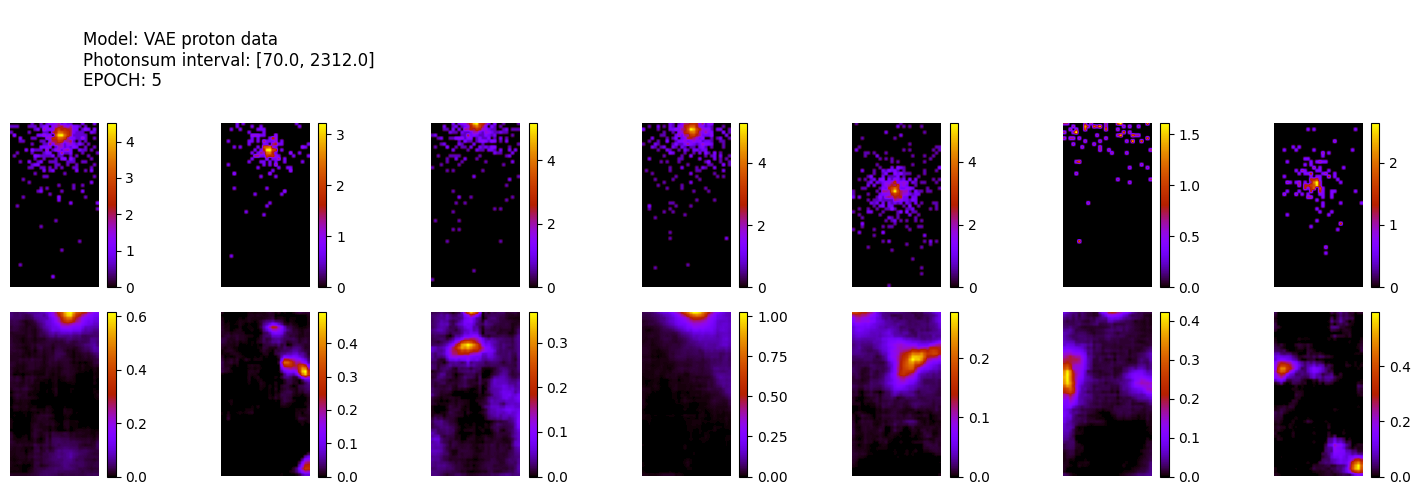

256/256 [==============================] - 1s 4ms/step
ws mean 118.40 ch1 0.15 ch2 96.57 ch3 0.76 ch4 198.76 ch5 295.77 Time for epoch 5 is 15.327054977416992 sec
1300 [Total loss: 96.15] [Recon_loss: 96.15] [KL loss: 0.00]
1400 [Total loss: 96.08] [Recon_loss: 96.08] [KL loss: 0.00]
1500 [Total loss: 85.01] [Recon_loss: 85.01] [KL loss: 0.00]


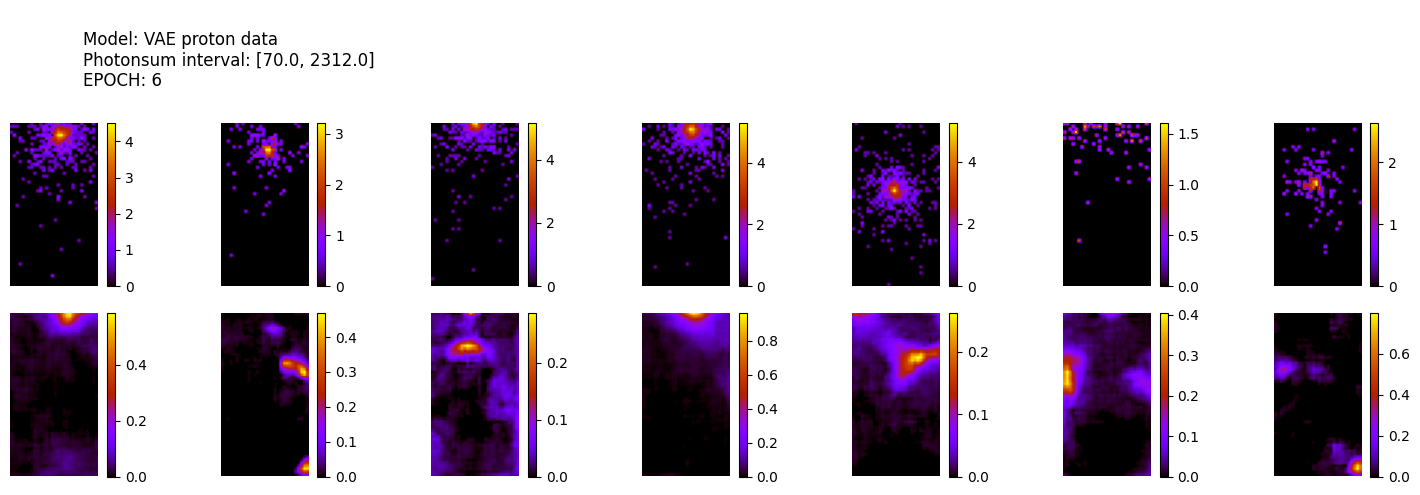

256/256 [==============================] - 1s 4ms/step
ws mean 120.78 ch1 0.17 ch2 100.28 ch3 0.76 ch4 200.96 ch5 301.71 Time for epoch 6 is 17.513105869293213 sec
1600 [Total loss: 95.88] [Recon_loss: 95.88] [KL loss: 0.00]
1700 [Total loss: 90.42] [Recon_loss: 90.42] [KL loss: 0.00]


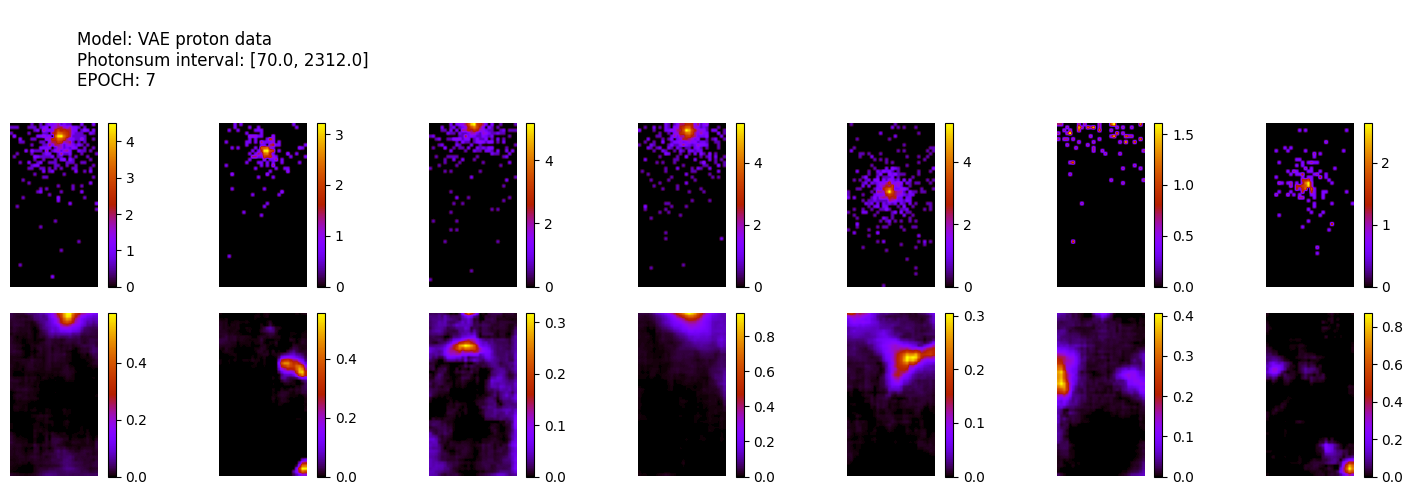

256/256 [==============================] - 1s 4ms/step
ws mean 121.05 ch1 0.16 ch2 100.48 ch3 0.77 ch4 201.46 ch5 302.40 Time for epoch 7 is 17.313310146331787 sec
1800 [Total loss: 94.41] [Recon_loss: 94.41] [KL loss: 0.00]
1900 [Total loss: 85.01] [Recon_loss: 85.01] [KL loss: 0.00]
2000 [Total loss: 88.42] [Recon_loss: 88.42] [KL loss: 0.00]


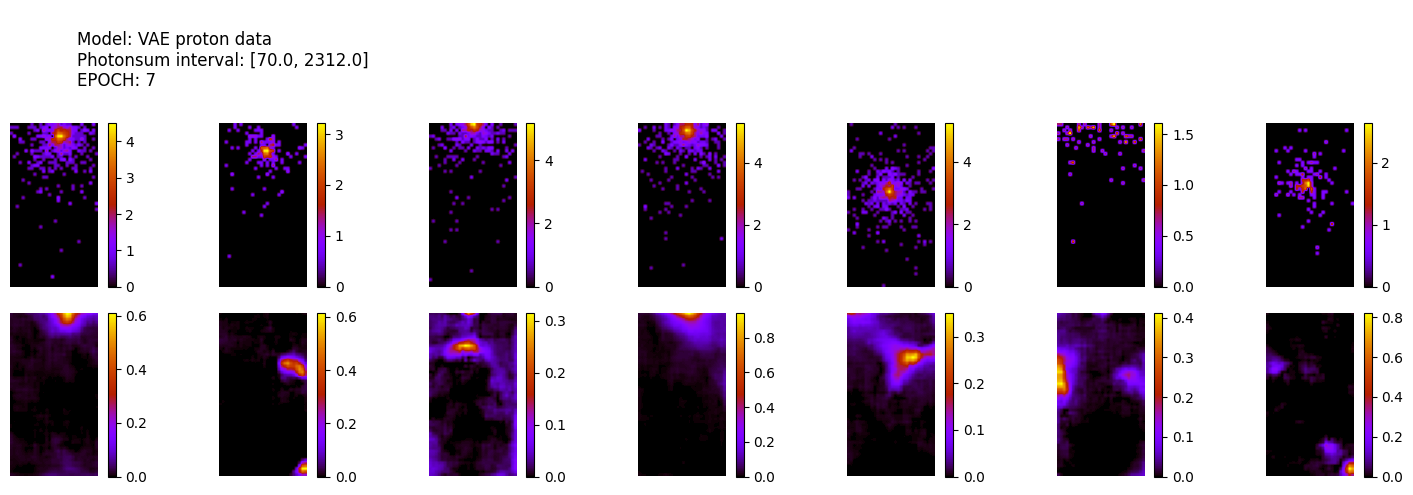

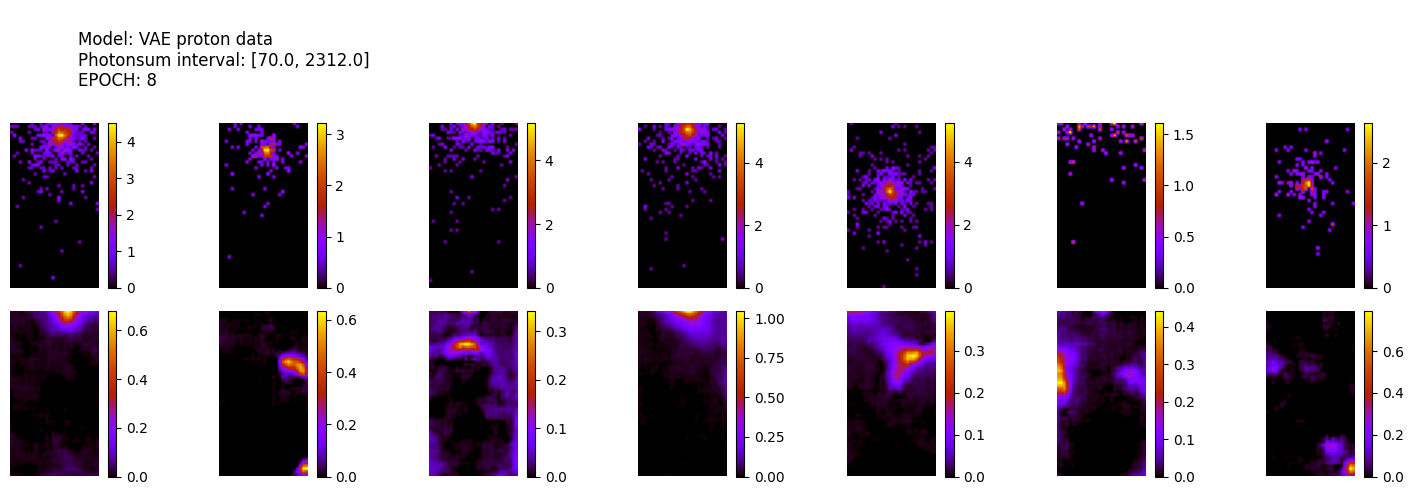

256/256 [==============================] - 1s 4ms/step
ws mean 120.73 ch1 0.16 ch2 99.84 ch3 0.77 ch4 201.26 ch5 301.61 Time for epoch 8 is 19.468247175216675 sec
2100 [Total loss: 92.19] [Recon_loss: 92.19] [KL loss: 0.00]
2200 [Total loss: 95.39] [Recon_loss: 95.39] [KL loss: 0.00]
2300 [Total loss: 89.68] [Recon_loss: 89.68] [KL loss: 0.00]


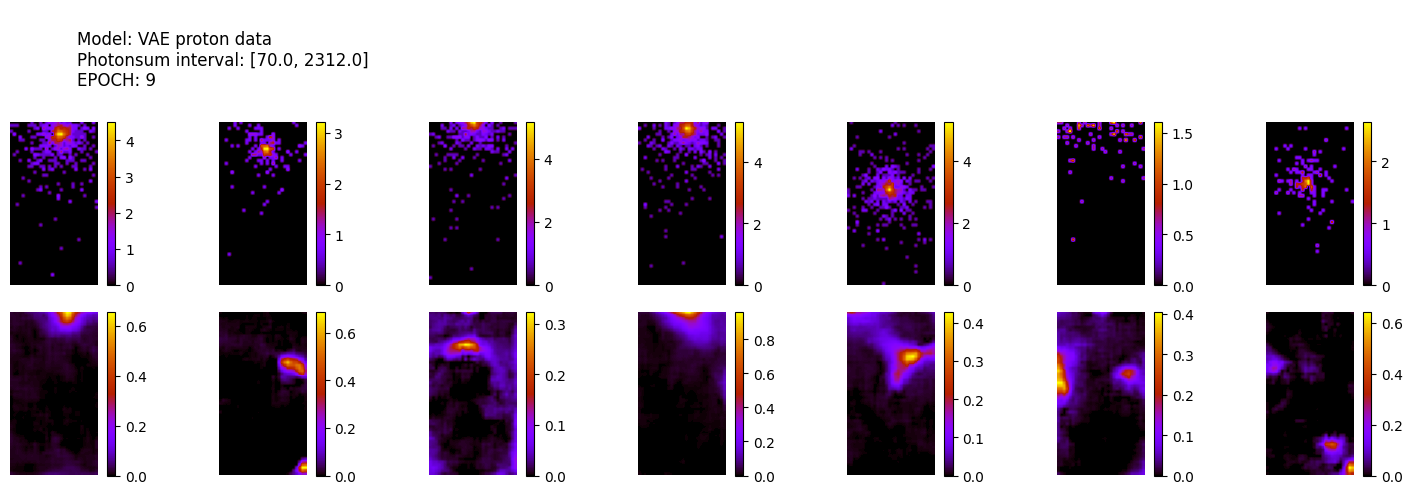

256/256 [==============================] - 1s 4ms/step
ws mean 120.45 ch1 0.16 ch2 99.29 ch3 0.77 ch4 201.16 ch5 300.89 Time for epoch 9 is 17.415920972824097 sec
2400 [Total loss: 94.13] [Recon_loss: 94.13] [KL loss: 0.00]
2500 [Total loss: 91.34] [Recon_loss: 91.34] [KL loss: 0.00]


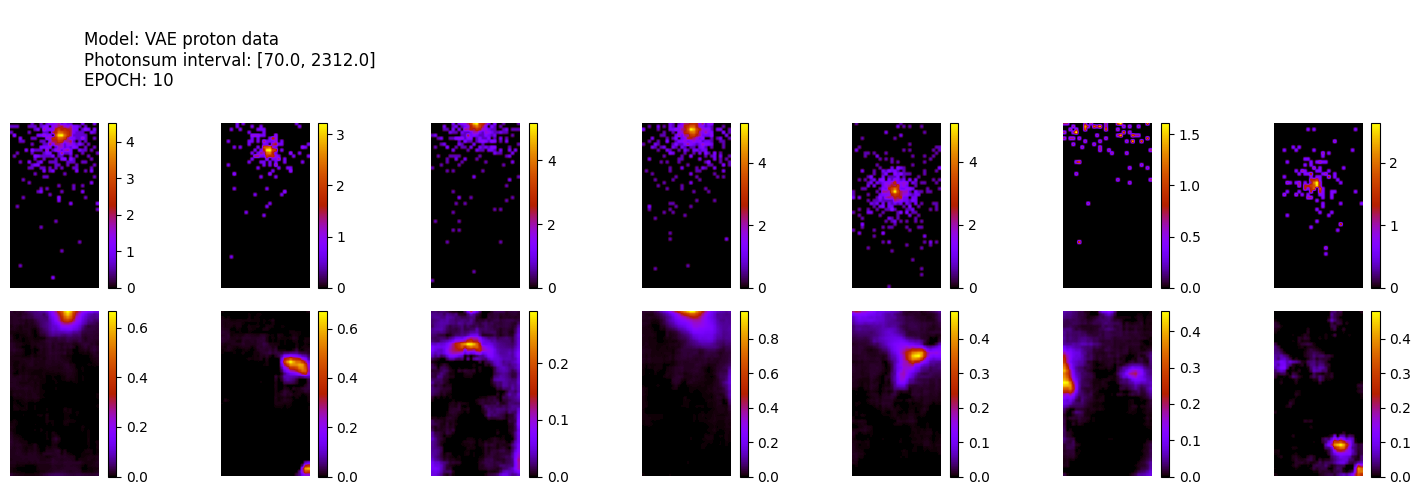

256/256 [==============================] - 1s 4ms/step
ws mean 120.94 ch1 0.17 ch2 100.15 ch3 0.77 ch4 201.48 ch5 302.14 Time for epoch 10 is 17.848978281021118 sec
2600 [Total loss: 98.23] [Recon_loss: 98.23] [KL loss: 0.00]
2700 [Total loss: 88.61] [Recon_loss: 88.61] [KL loss: 0.00]
2800 [Total loss: 91.80] [Recon_loss: 91.80] [KL loss: 0.00]


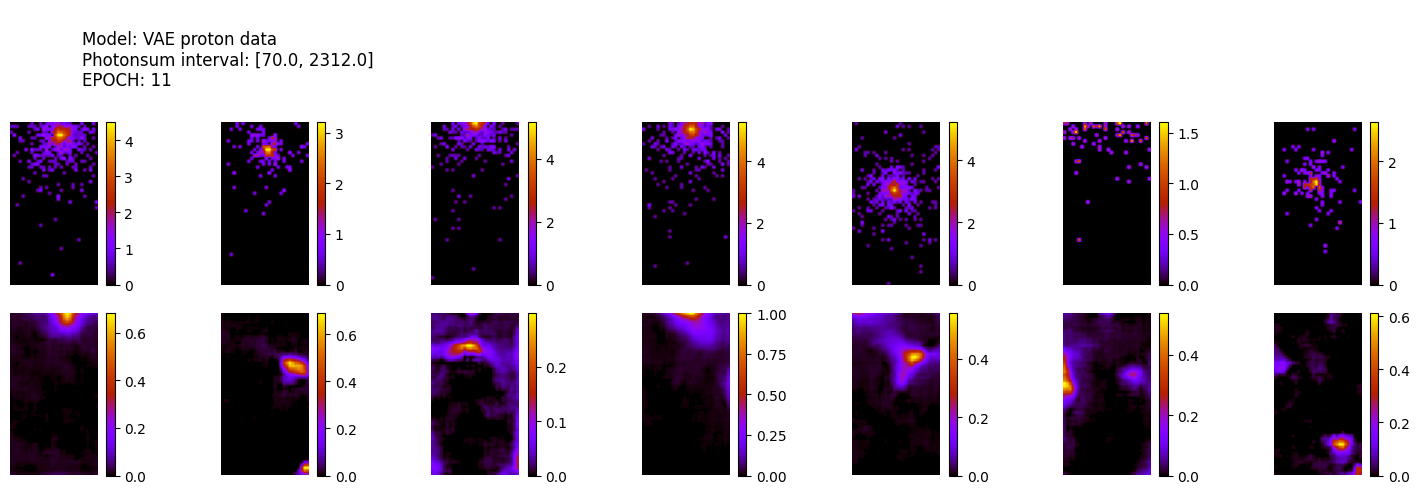

256/256 [==============================] - 1s 4ms/step
ws mean 120.04 ch1 0.15 ch2 98.49 ch3 0.76 ch4 200.90 ch5 299.88 Time for epoch 11 is 19.836382150650024 sec
2900 [Total loss: 84.95] [Recon_loss: 84.95] [KL loss: 0.00]
3000 [Total loss: 95.54] [Recon_loss: 95.54] [KL loss: 0.00]


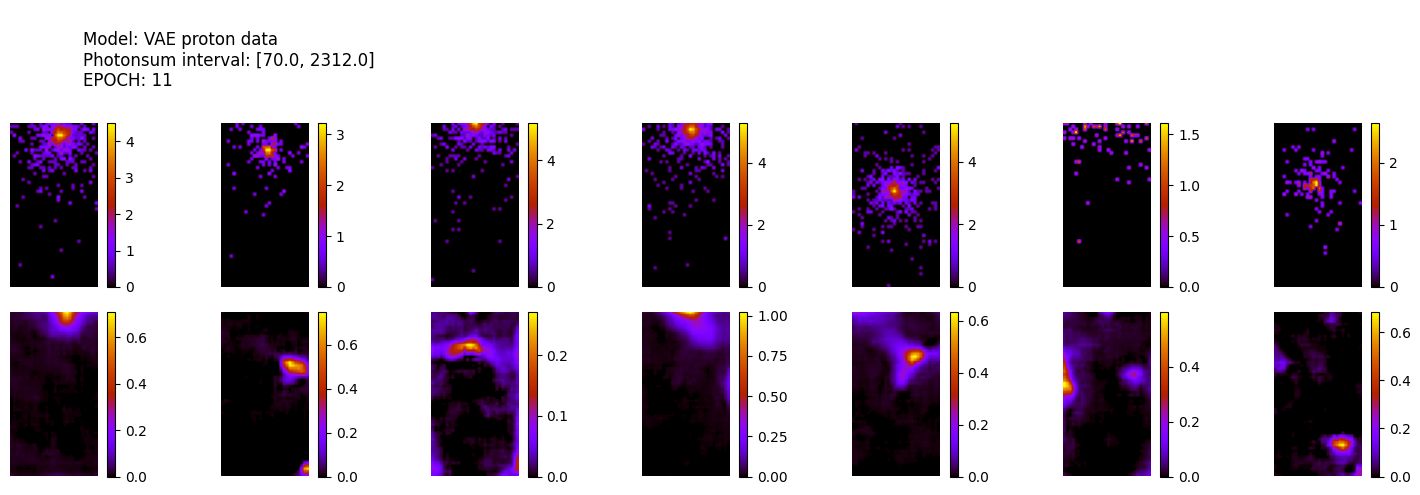

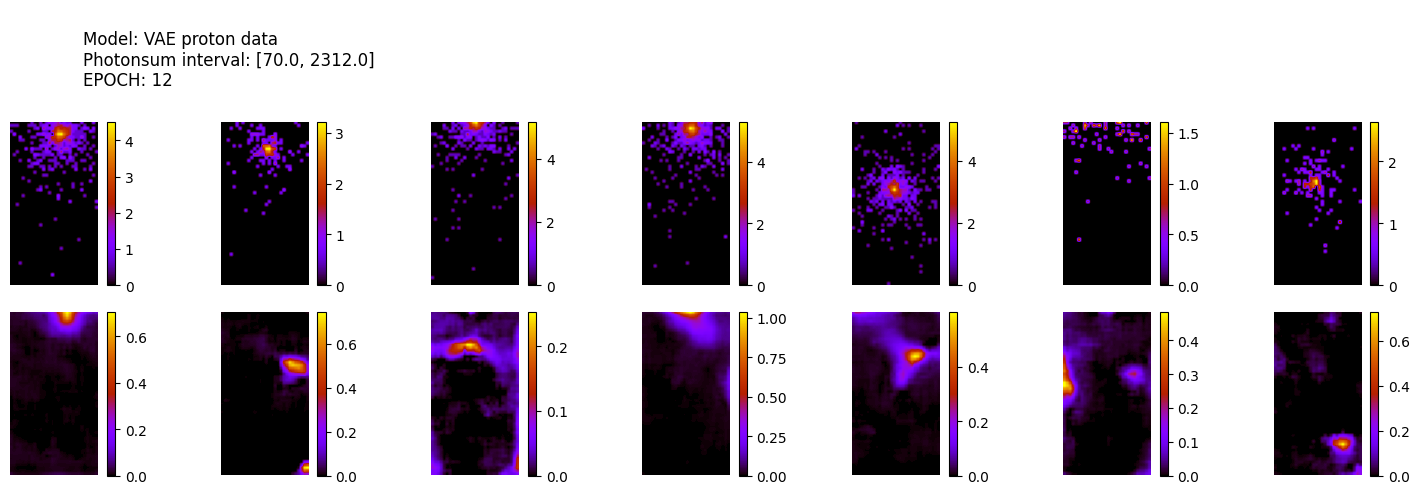

256/256 [==============================] - 1s 4ms/step
ws mean 120.10 ch1 0.15 ch2 98.50 ch3 0.76 ch4 201.04 ch5 300.04 Time for epoch 12 is 21.484305381774902 sec
3100 [Total loss: 89.97] [Recon_loss: 89.97] [KL loss: 0.00]
3200 [Total loss: 91.12] [Recon_loss: 91.12] [KL loss: 0.00]
3300 [Total loss: 89.16] [Recon_loss: 89.16] [KL loss: 0.00]


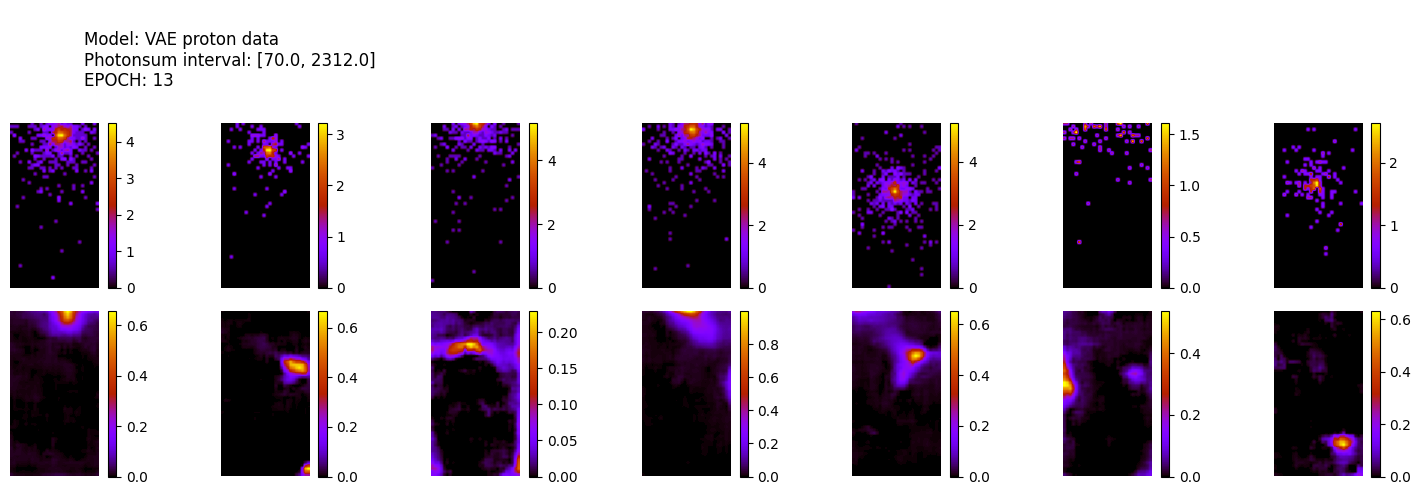

256/256 [==============================] - 1s 4ms/step
ws mean 120.34 ch1 0.16 ch2 98.84 ch3 0.77 ch4 201.28 ch5 300.63 Time for epoch 13 is 19.958001136779785 sec
3400 [Total loss: 95.03] [Recon_loss: 95.03] [KL loss: 0.00]
3500 [Total loss: 91.12] [Recon_loss: 91.12] [KL loss: 0.00]


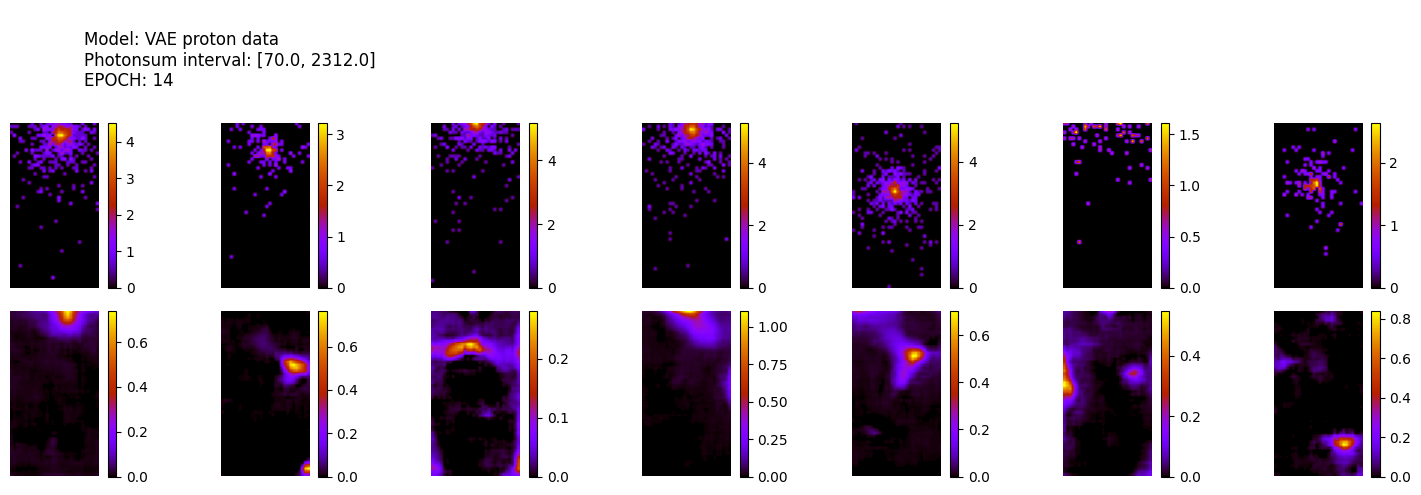

256/256 [==============================] - 1s 4ms/step
ws mean 117.85 ch1 0.14 ch2 94.90 ch3 0.76 ch4 199.06 ch5 294.41 Time for epoch 14 is 19.767512321472168 sec
3600 [Total loss: 85.84] [Recon_loss: 85.84] [KL loss: 0.00]
3700 [Total loss: 90.16] [Recon_loss: 90.16] [KL loss: 0.00]
3800 [Total loss: 91.61] [Recon_loss: 91.61] [KL loss: 0.00]


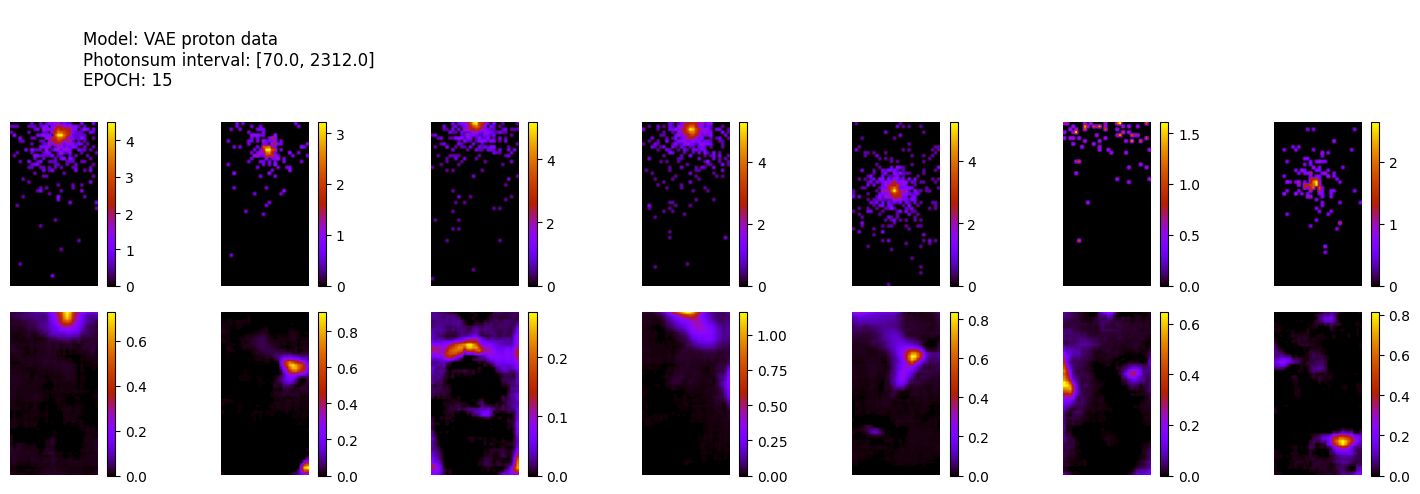

256/256 [==============================] - 1s 4ms/step
ws mean 117.02 ch1 0.14 ch2 93.10 ch3 0.76 ch4 198.76 ch5 292.31 Time for epoch 15 is 20.03515625 sec
3900 [Total loss: 94.50] [Recon_loss: 94.50] [KL loss: 0.00]
4000 [Total loss: 85.69] [Recon_loss: 85.69] [KL loss: 0.00]


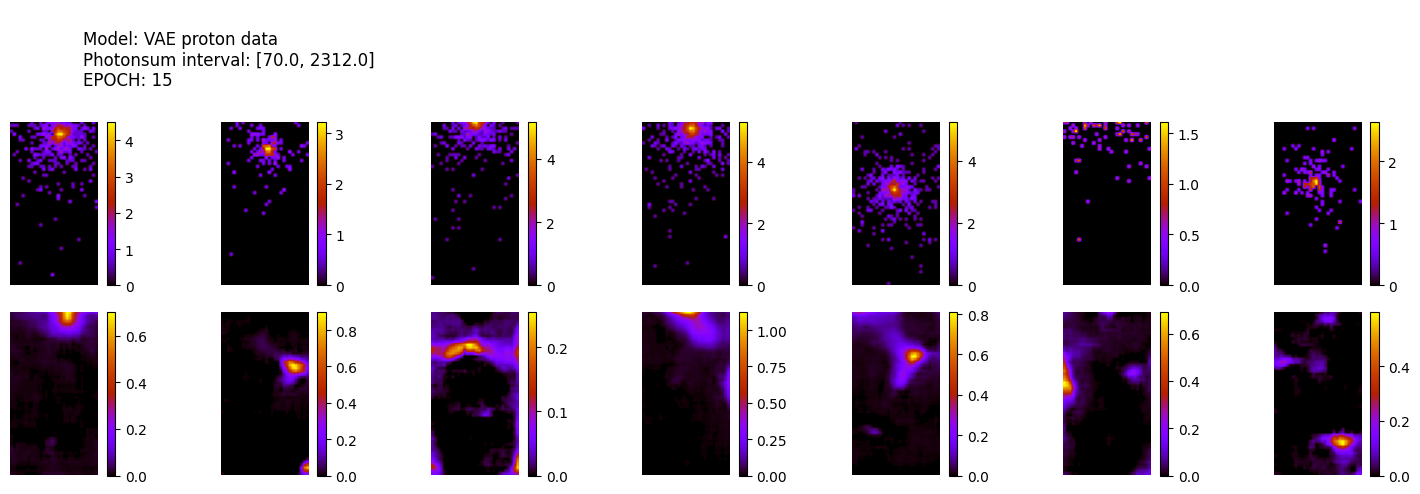

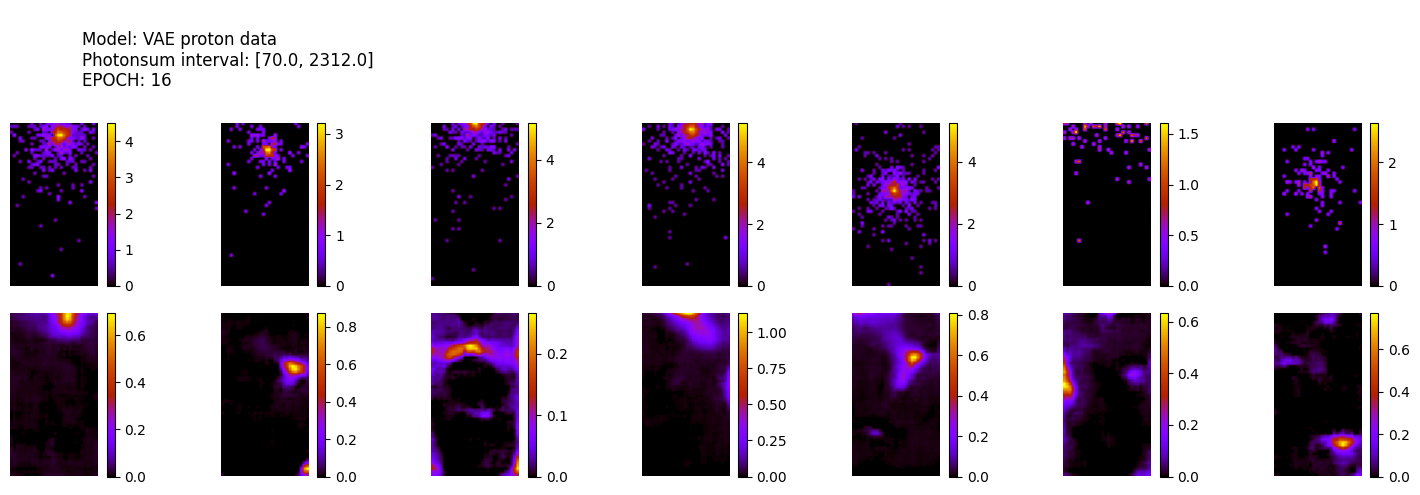

256/256 [==============================] - 1s 4ms/step
ws mean 117.01 ch1 0.14 ch2 93.35 ch3 0.76 ch4 198.52 ch5 292.29 Time for epoch 16 is 23.963186025619507 sec
4100 [Total loss: 93.06] [Recon_loss: 93.06] [KL loss: 0.00]
4200 [Total loss: 86.53] [Recon_loss: 86.53] [KL loss: 0.00]
4300 [Total loss: 84.99] [Recon_loss: 84.99] [KL loss: 0.00]


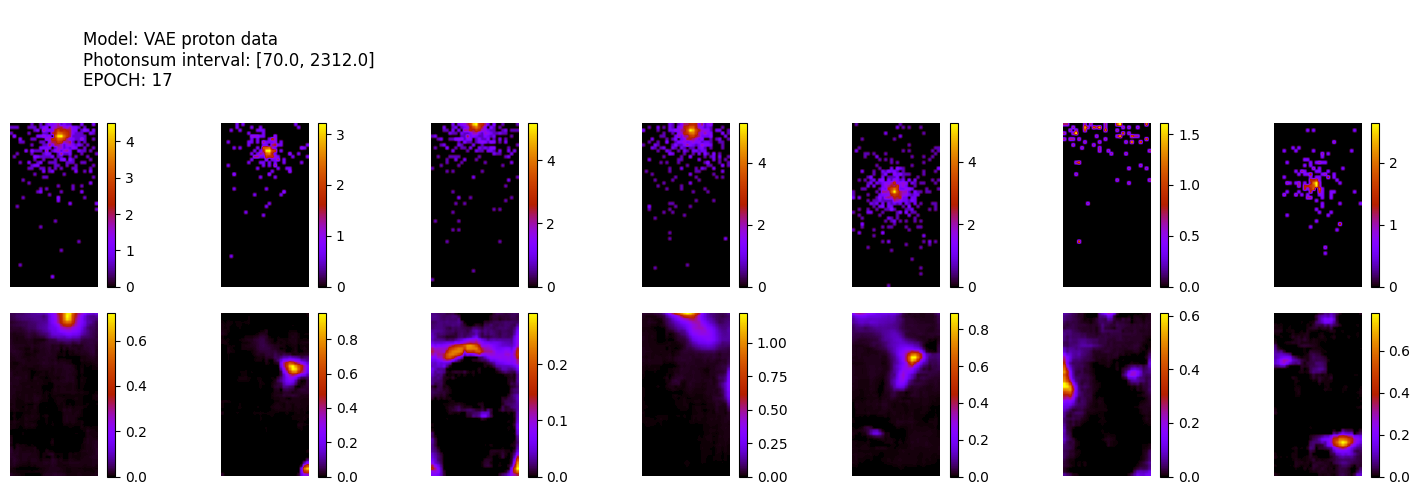

256/256 [==============================] - 1s 4ms/step
ws mean 117.09 ch1 0.15 ch2 93.55 ch3 0.76 ch4 198.51 ch5 292.48 Time for epoch 17 is 22.235907077789307 sec
4400 [Total loss: 87.00] [Recon_loss: 87.00] [KL loss: 0.00]
4500 [Total loss: 85.43] [Recon_loss: 85.43] [KL loss: 0.00]
4600 [Total loss: 88.47] [Recon_loss: 88.47] [KL loss: 0.00]


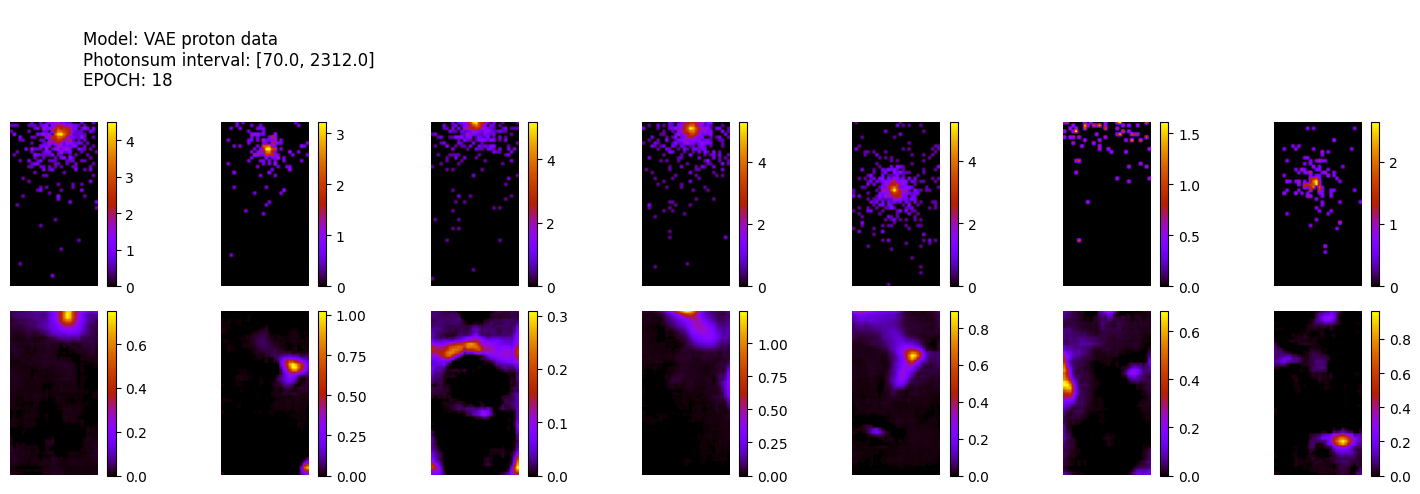

256/256 [==============================] - 1s 4ms/step
ws mean 116.40 ch1 0.14 ch2 92.59 ch3 0.75 ch4 197.75 ch5 290.75 Time for epoch 18 is 22.22015643119812 sec
4700 [Total loss: 90.82] [Recon_loss: 90.82] [KL loss: 0.00]
4800 [Total loss: 88.96] [Recon_loss: 88.96] [KL loss: 0.00]


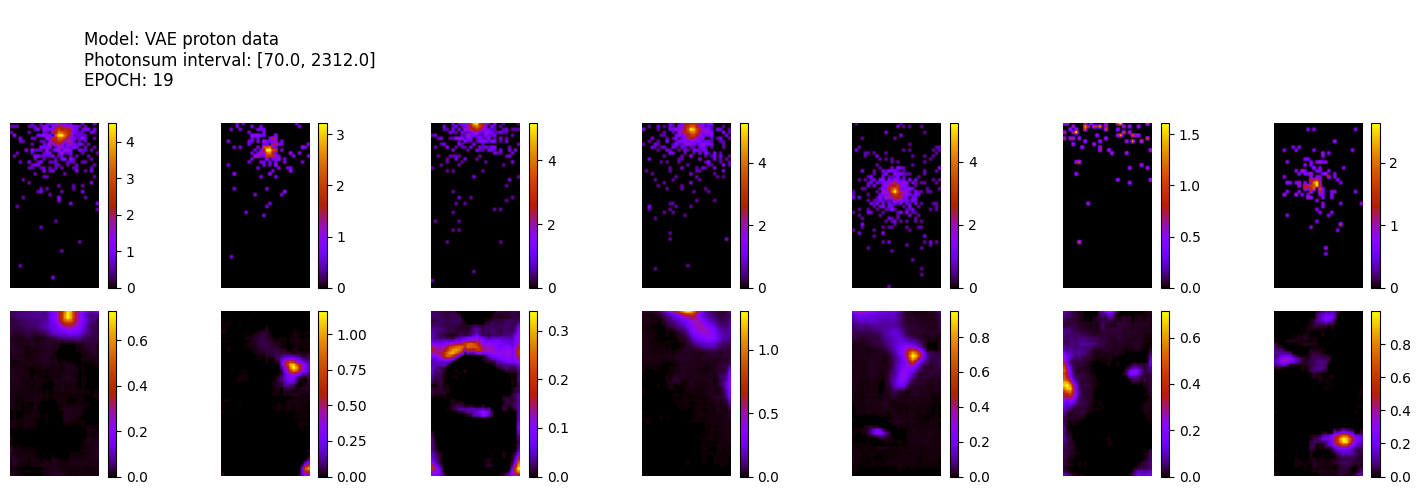

256/256 [==============================] - 1s 4ms/step
ws mean 116.44 ch1 0.14 ch2 92.66 ch3 0.75 ch4 197.77 ch5 290.87 Time for epoch 19 is 22.26480269432068 sec
4900 [Total loss: 88.47] [Recon_loss: 88.47] [KL loss: 0.00]
5000 [Total loss: 89.63] [Recon_loss: 89.63] [KL loss: 0.00]


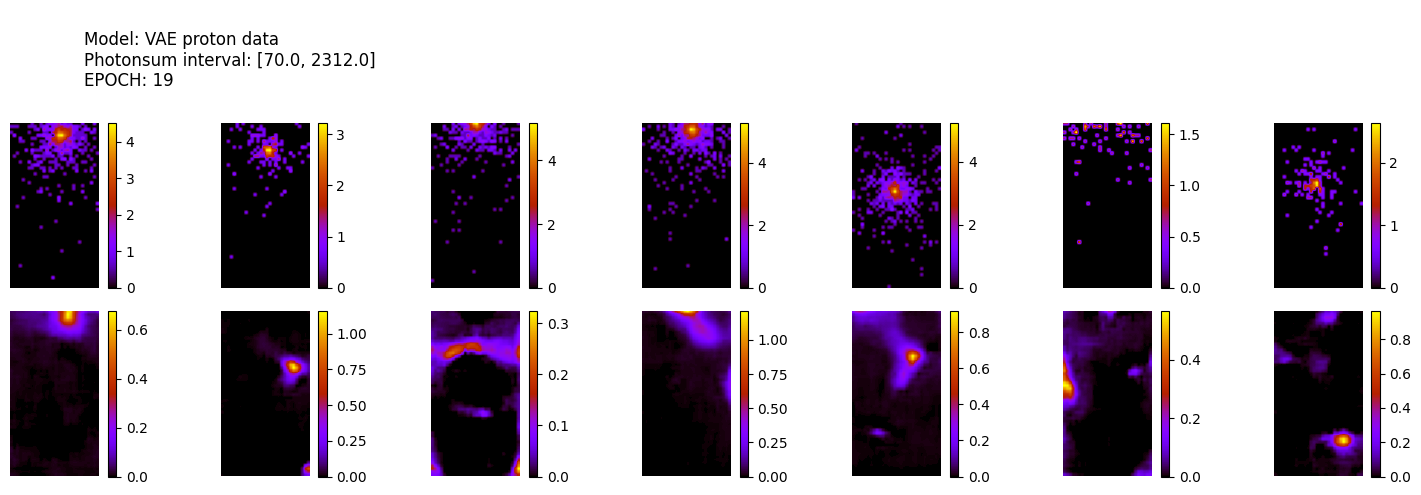

5100 [Total loss: 84.76] [Recon_loss: 84.76] [KL loss: 0.00]


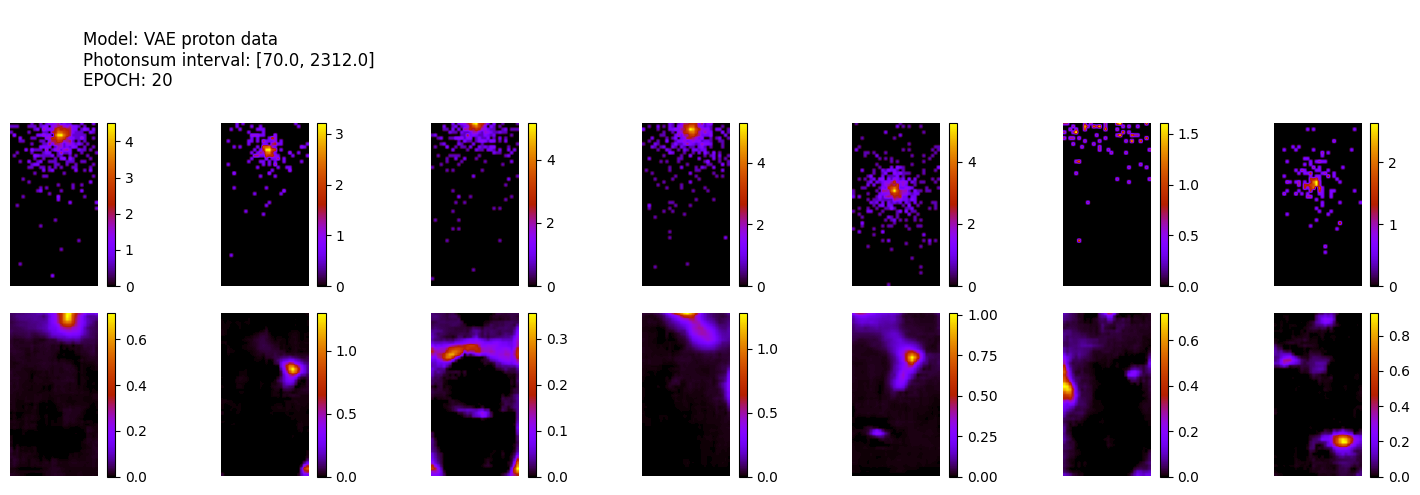

256/256 [==============================] - 1s 4ms/step
ws mean 115.42 ch1 0.13 ch2 91.02 ch3 0.75 ch4 196.87 ch5 288.34 Time for epoch 20 is 23.844411373138428 sec
5200 [Total loss: 82.92] [Recon_loss: 82.92] [KL loss: 0.00]
5300 [Total loss: 86.16] [Recon_loss: 86.16] [KL loss: 0.00]


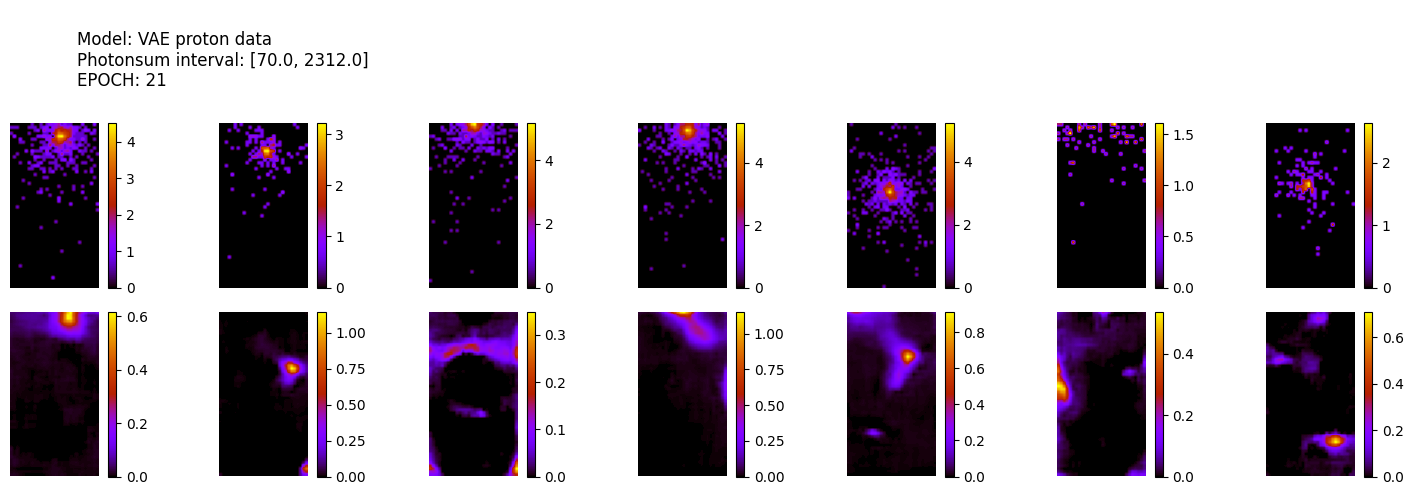

256/256 [==============================] - 1s 4ms/step
ws mean 118.53 ch1 0.15 ch2 96.59 ch3 0.76 ch4 199.07 ch5 296.11 Time for epoch 21 is 24.51424789428711 sec
5400 [Total loss: 88.25] [Recon_loss: 88.25] [KL loss: 0.00]
5500 [Total loss: 82.45] [Recon_loss: 82.45] [KL loss: 0.00]
5600 [Total loss: 87.64] [Recon_loss: 87.64] [KL loss: 0.00]


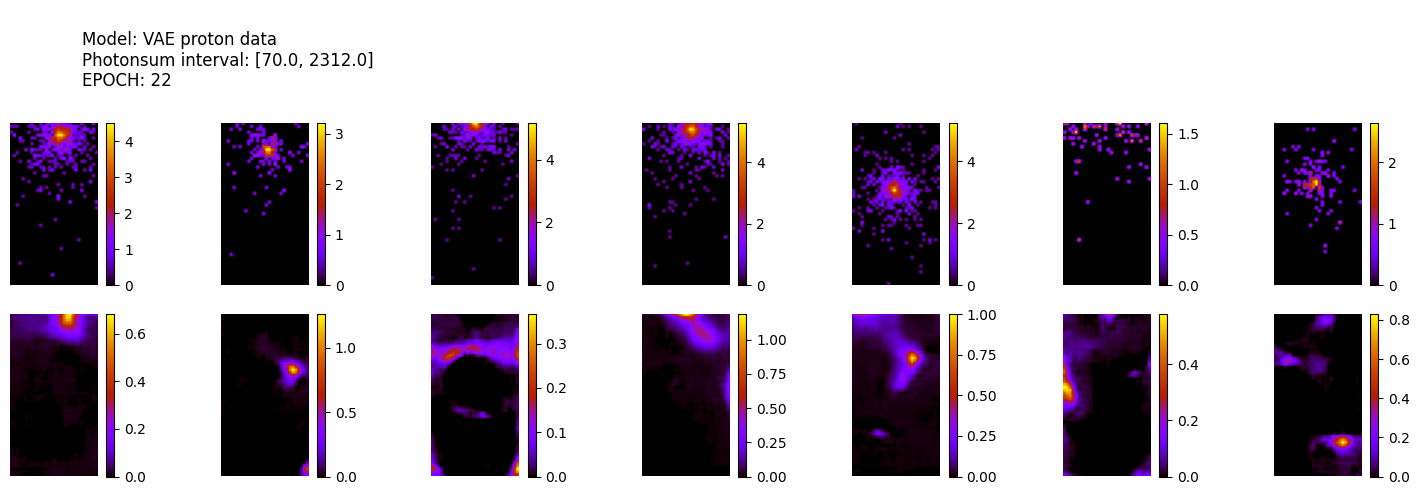

256/256 [==============================] - 1s 4ms/step
ws mean 118.28 ch1 0.14 ch2 96.41 ch3 0.76 ch4 198.61 ch5 295.48 Time for epoch 22 is 24.20544457435608 sec
5700 [Total loss: 95.14] [Recon_loss: 95.14] [KL loss: 0.00]
5800 [Total loss: 91.43] [Recon_loss: 91.43] [KL loss: 0.00]


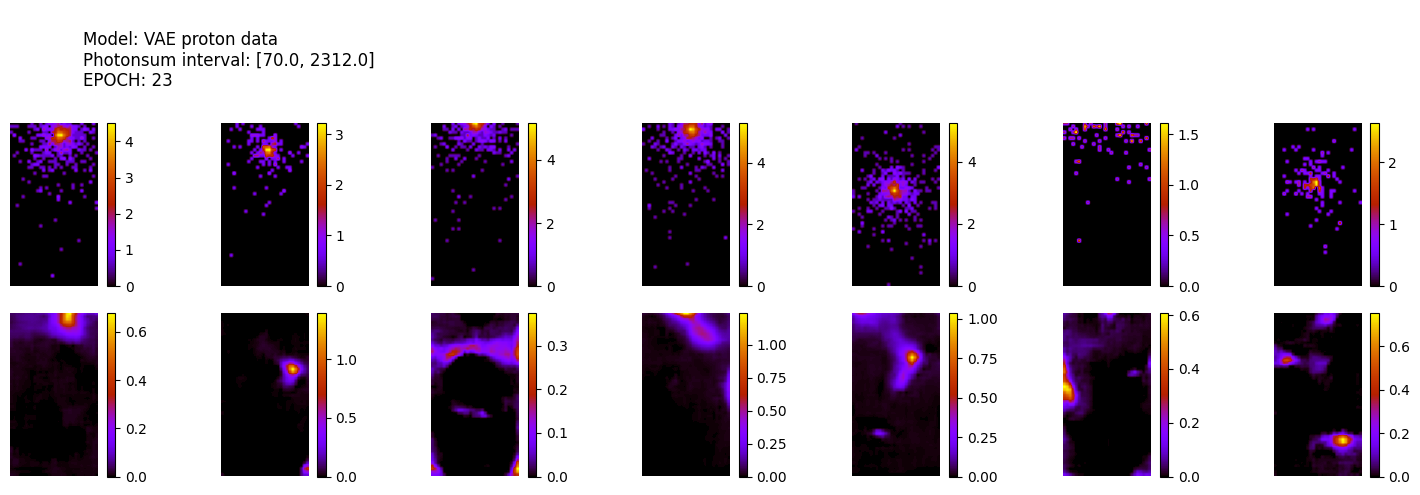

256/256 [==============================] - 1s 4ms/step
ws mean 117.69 ch1 0.15 ch2 95.29 ch3 0.76 ch4 198.26 ch5 294.01 Time for epoch 23 is 24.388893365859985 sec
5900 [Total loss: 92.26] [Recon_loss: 92.26] [KL loss: 0.00]
6000 [Total loss: 85.83] [Recon_loss: 85.83] [KL loss: 0.00]


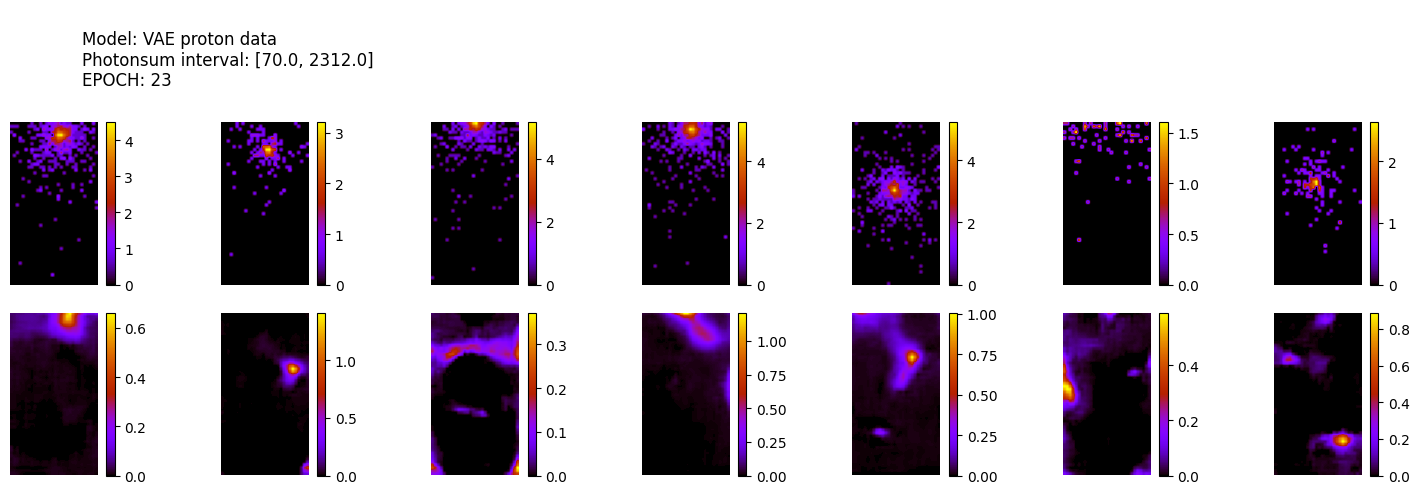

6100 [Total loss: 92.77] [Recon_loss: 92.77] [KL loss: 0.00]


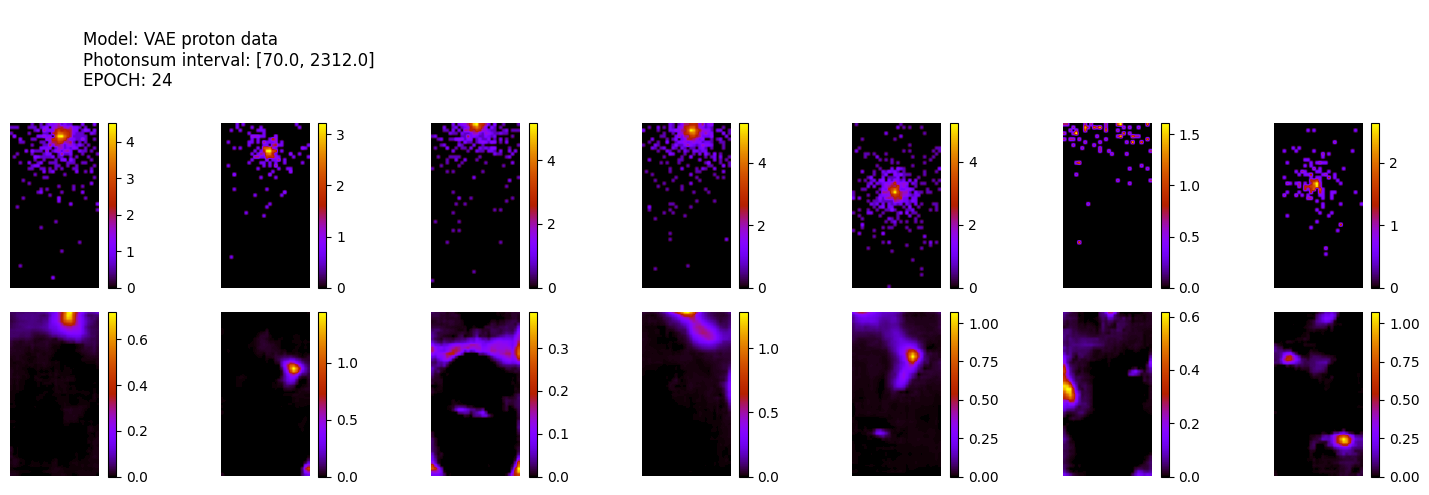

256/256 [==============================] - 1s 4ms/step
ws mean 117.58 ch1 0.15 ch2 95.31 ch3 0.75 ch4 197.95 ch5 293.72 Time for epoch 24 is 26.267908811569214 sec
6200 [Total loss: 89.85] [Recon_loss: 89.85] [KL loss: 0.00]
6300 [Total loss: 87.28] [Recon_loss: 87.28] [KL loss: 0.00]
6400 [Total loss: 91.90] [Recon_loss: 91.90] [KL loss: 0.00]


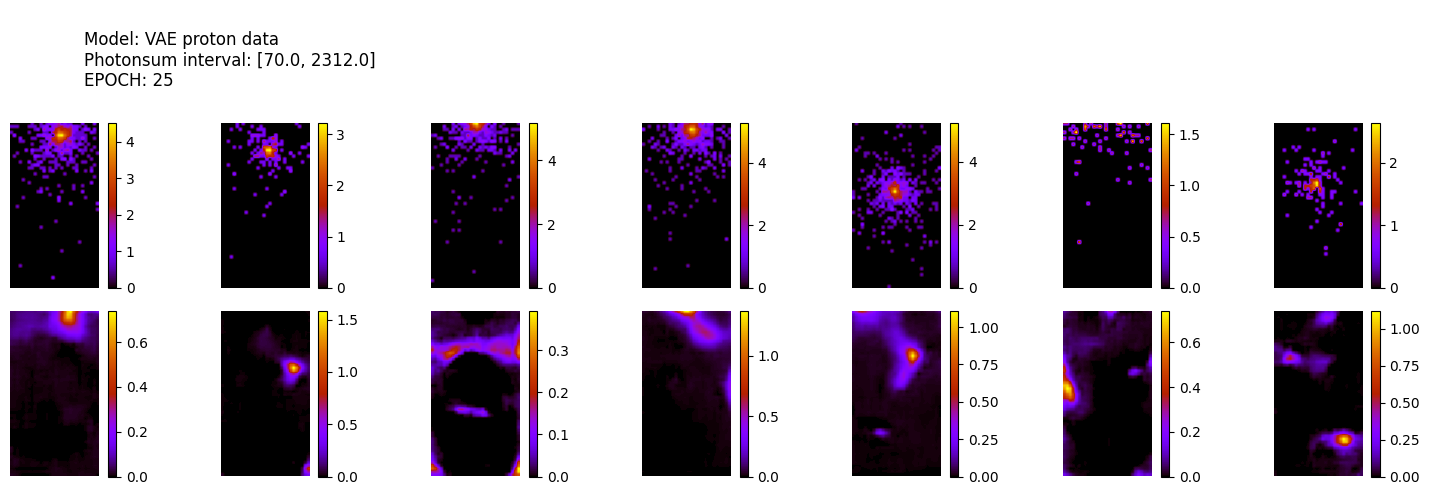

256/256 [==============================] - 1s 4ms/step
ws mean 115.30 ch1 0.13 ch2 91.47 ch3 0.75 ch4 196.12 ch5 288.04 Time for epoch 25 is 24.269674062728882 sec
6500 [Total loss: 89.39] [Recon_loss: 89.39] [KL loss: 0.00]
6600 [Total loss: 90.40] [Recon_loss: 90.40] [KL loss: 0.00]


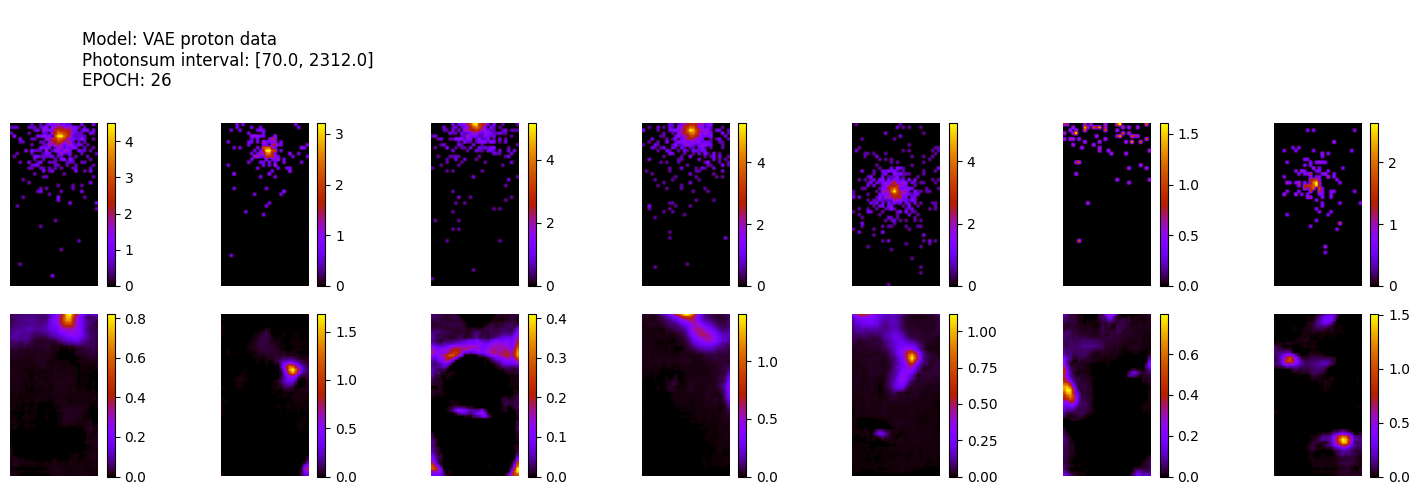

256/256 [==============================] - 1s 4ms/step
ws mean 114.56 ch1 0.12 ch2 90.65 ch3 0.75 ch4 195.10 ch5 286.16 Time for epoch 26 is 24.439583778381348 sec
6700 [Total loss: 84.11] [Recon_loss: 84.11] [KL loss: 0.00]
6800 [Total loss: 90.86] [Recon_loss: 90.86] [KL loss: 0.00]
6900 [Total loss: 90.40] [Recon_loss: 90.40] [KL loss: 0.00]


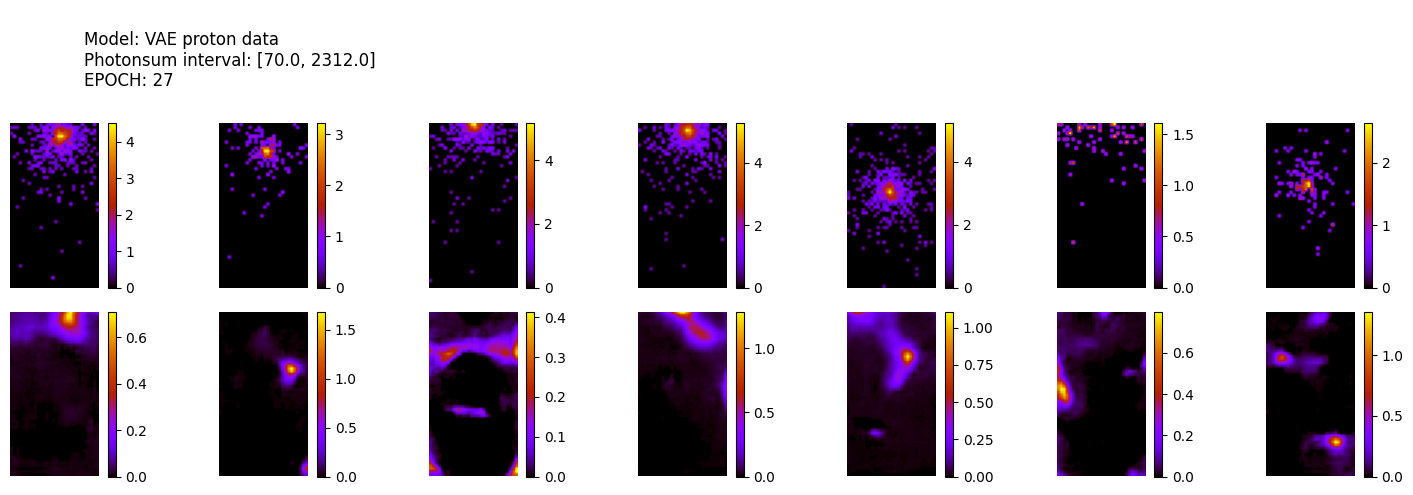

256/256 [==============================] - 1s 4ms/step
ws mean 114.03 ch1 0.12 ch2 89.67 ch3 0.75 ch4 194.76 ch5 284.86 Time for epoch 27 is 24.493976354599 sec
7000 [Total loss: 86.36] [Recon_loss: 86.36] [KL loss: 0.00]


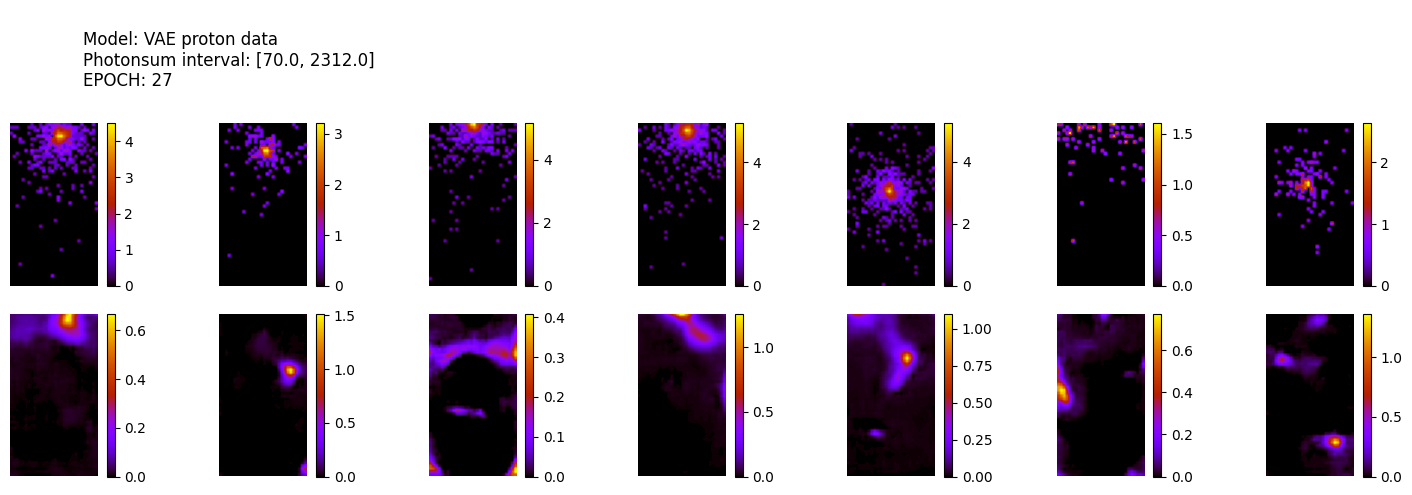

7100 [Total loss: 92.92] [Recon_loss: 92.92] [KL loss: 0.00]


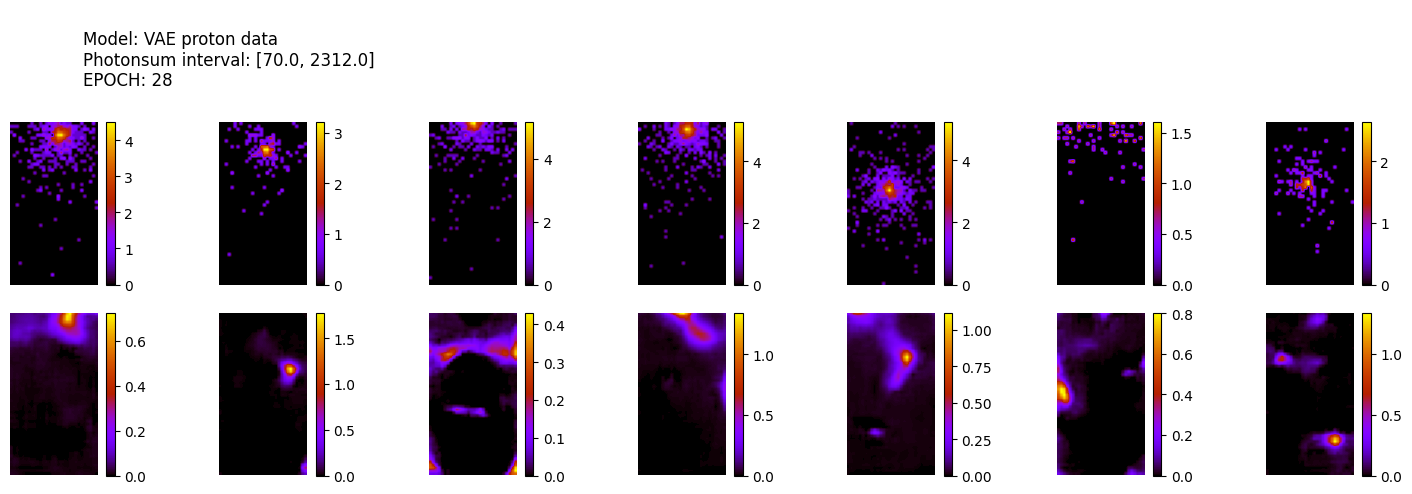

256/256 [==============================] - 1s 4ms/step
ws mean 113.87 ch1 0.12 ch2 89.52 ch3 0.74 ch4 194.51 ch5 284.44 Time for epoch 28 is 25.991185903549194 sec
7200 [Total loss: 86.17] [Recon_loss: 86.17] [KL loss: 0.00]
7300 [Total loss: 83.14] [Recon_loss: 83.14] [KL loss: 0.00]
7400 [Total loss: 88.90] [Recon_loss: 88.90] [KL loss: 0.00]


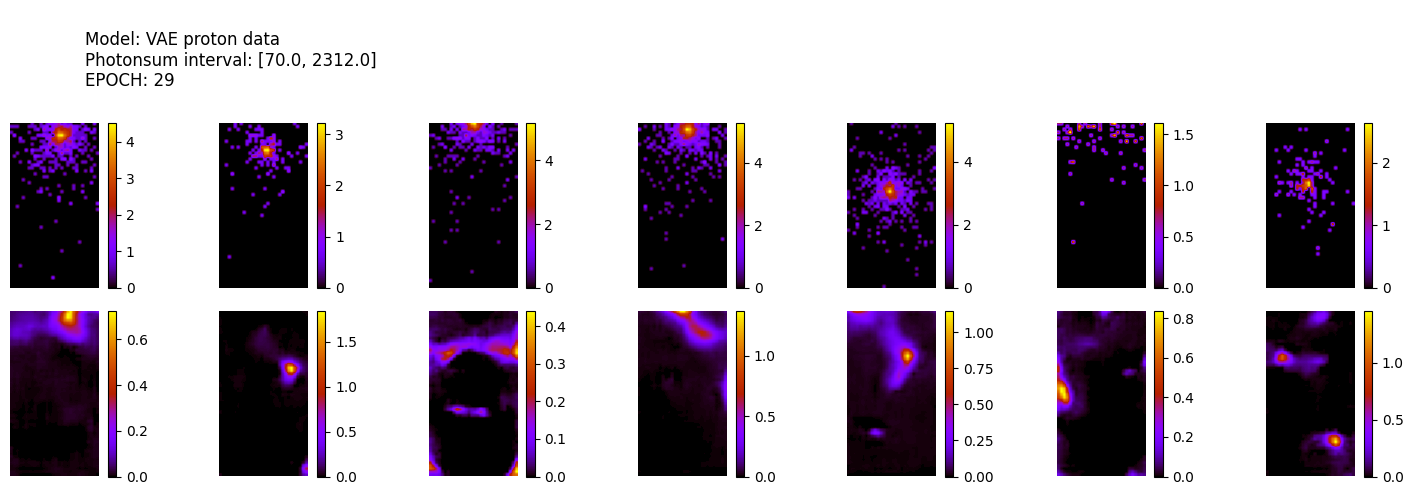

256/256 [==============================] - 1s 4ms/step
ws mean 113.27 ch1 0.13 ch2 88.65 ch3 0.74 ch4 193.86 ch5 282.95 Time for epoch 29 is 24.55982494354248 sec
7500 [Total loss: 92.83] [Recon_loss: 92.83] [KL loss: 0.00]
7600 [Total loss: 88.81] [Recon_loss: 88.81] [KL loss: 0.00]


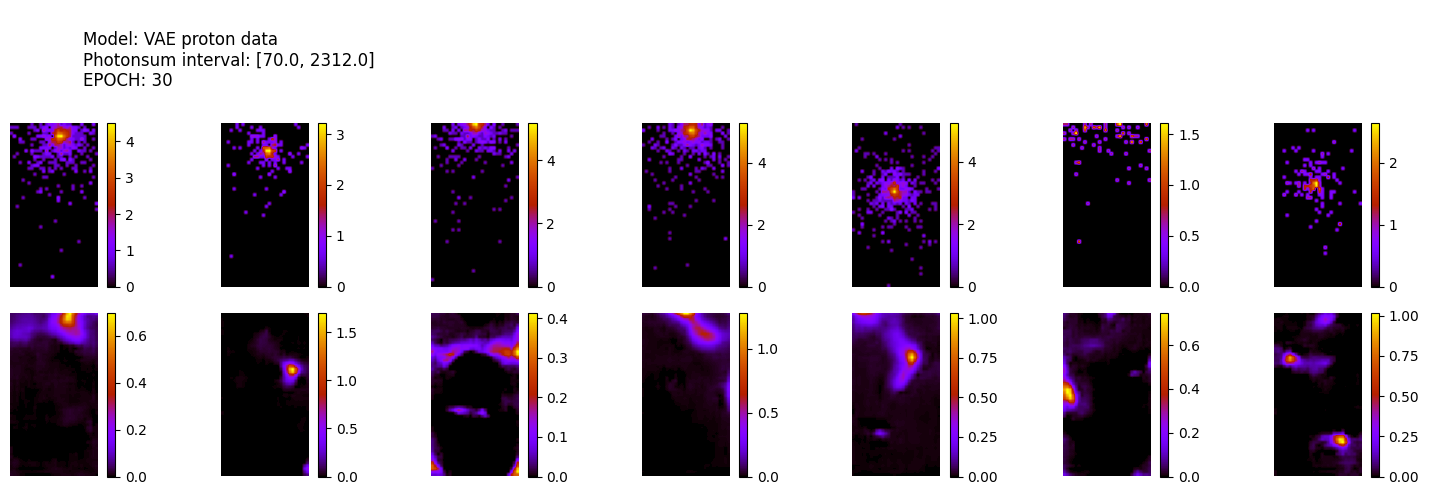

256/256 [==============================] - 1s 4ms/step
ws mean 115.85 ch1 0.13 ch2 93.08 ch3 0.74 ch4 195.91 ch5 289.41 Time for epoch 30 is 24.504924058914185 sec
7700 [Total loss: 89.17] [Recon_loss: 89.17] [KL loss: 0.00]
7800 [Total loss: 93.65] [Recon_loss: 93.65] [KL loss: 0.00]
7900 [Total loss: 89.61] [Recon_loss: 89.61] [KL loss: 0.00]


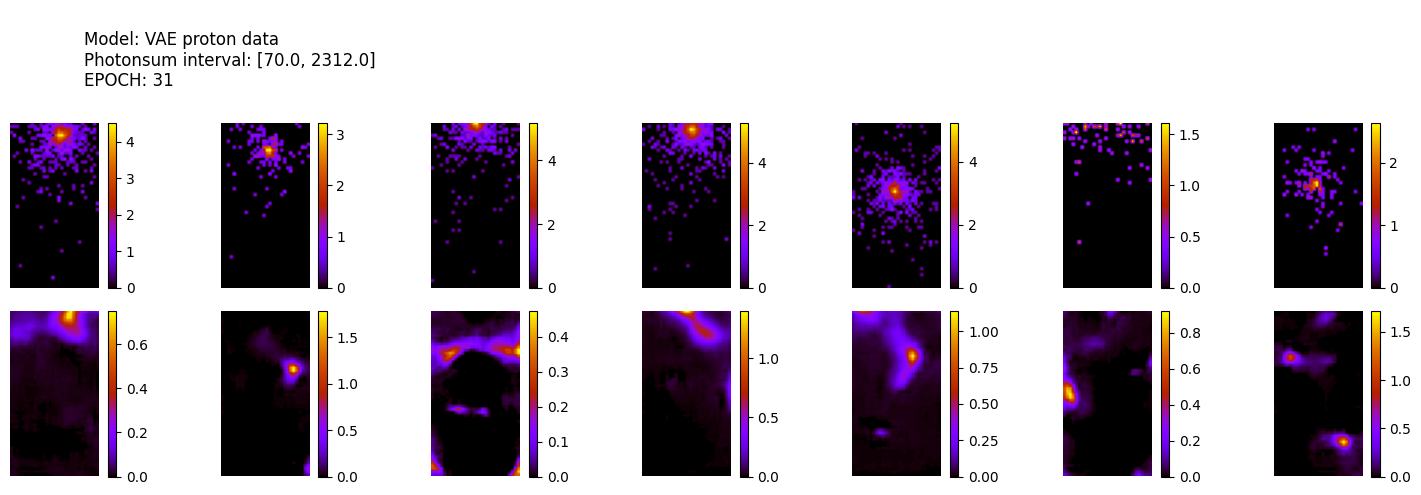

256/256 [==============================] - 1s 4ms/step
ws mean 113.09 ch1 0.11 ch2 88.33 ch3 0.75 ch4 193.77 ch5 282.50 Time for epoch 31 is 24.5203857421875 sec
8000 [Total loss: 92.48] [Recon_loss: 92.48] [KL loss: 0.00]


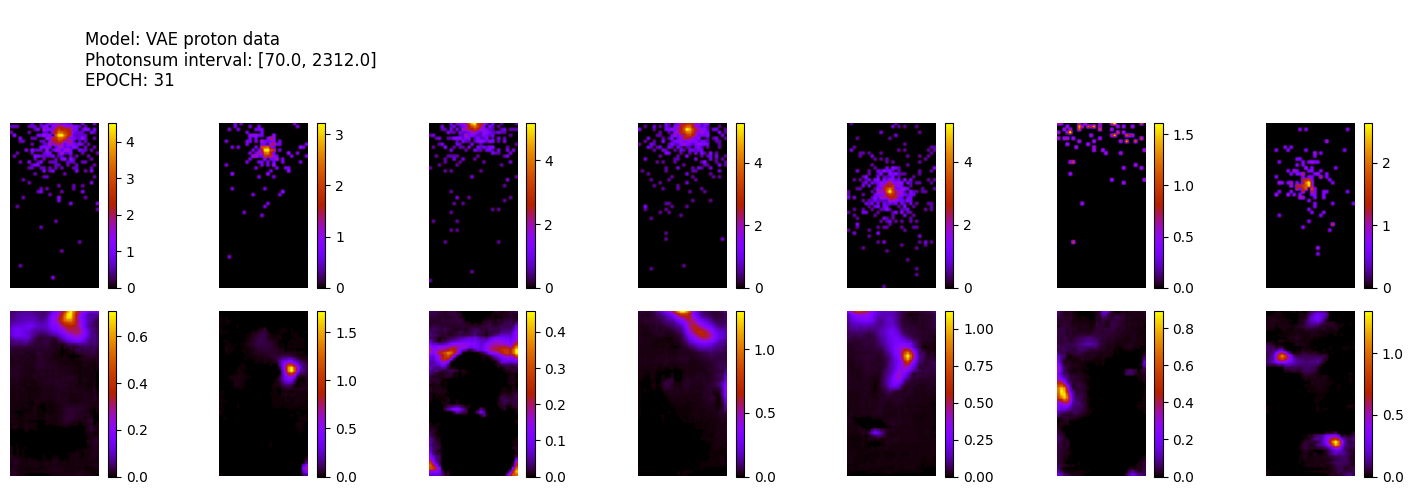

8100 [Total loss: 89.65] [Recon_loss: 89.65] [KL loss: 0.00]


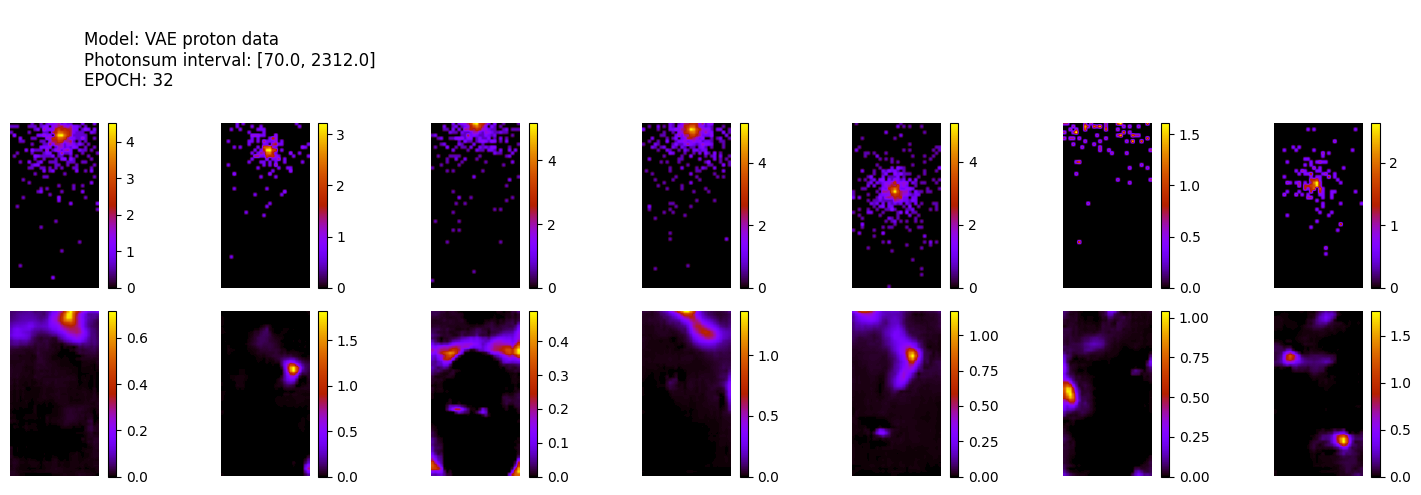

256/256 [==============================] - 1s 4ms/step
ws mean 112.93 ch1 0.12 ch2 88.11 ch3 0.74 ch4 193.58 ch5 282.10 Time for epoch 32 is 26.07590413093567 sec
8200 [Total loss: 84.58] [Recon_loss: 84.58] [KL loss: 0.00]
8300 [Total loss: 91.59] [Recon_loss: 91.59] [KL loss: 0.00]
8400 [Total loss: 90.30] [Recon_loss: 90.30] [KL loss: 0.00]


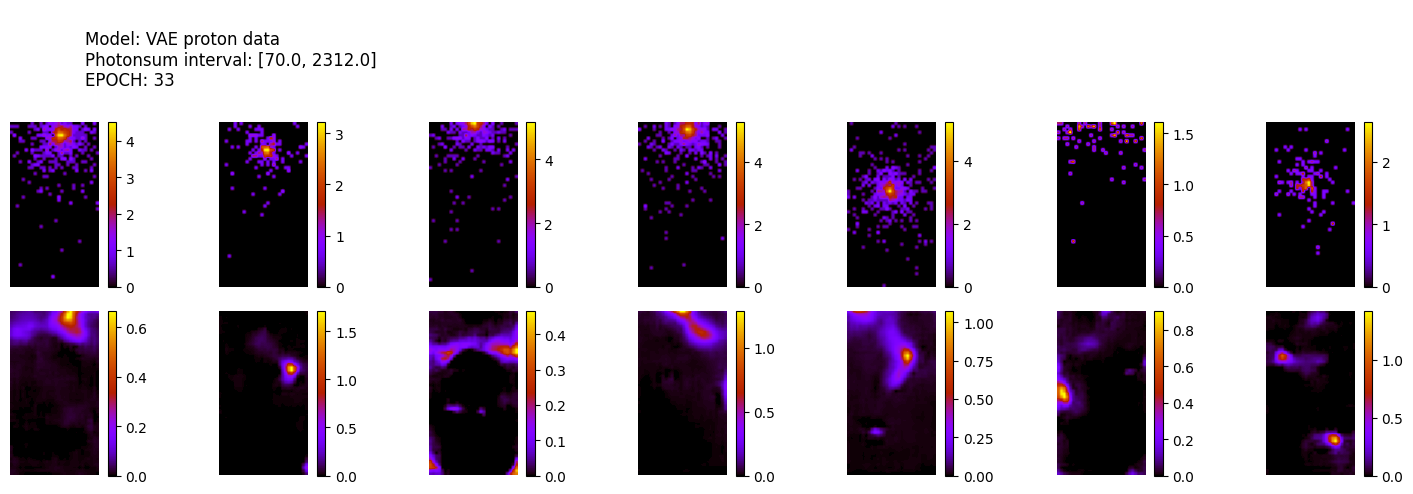

256/256 [==============================] - 1s 4ms/step
ws mean 114.74 ch1 0.12 ch2 91.13 ch3 0.74 ch4 195.07 ch5 286.64 Time for epoch 33 is 24.46984076499939 sec
8500 [Total loss: 89.34] [Recon_loss: 89.34] [KL loss: 0.00]
8600 [Total loss: 84.93] [Recon_loss: 84.93] [KL loss: 0.00]
8700 [Total loss: 91.58] [Recon_loss: 91.58] [KL loss: 0.00]


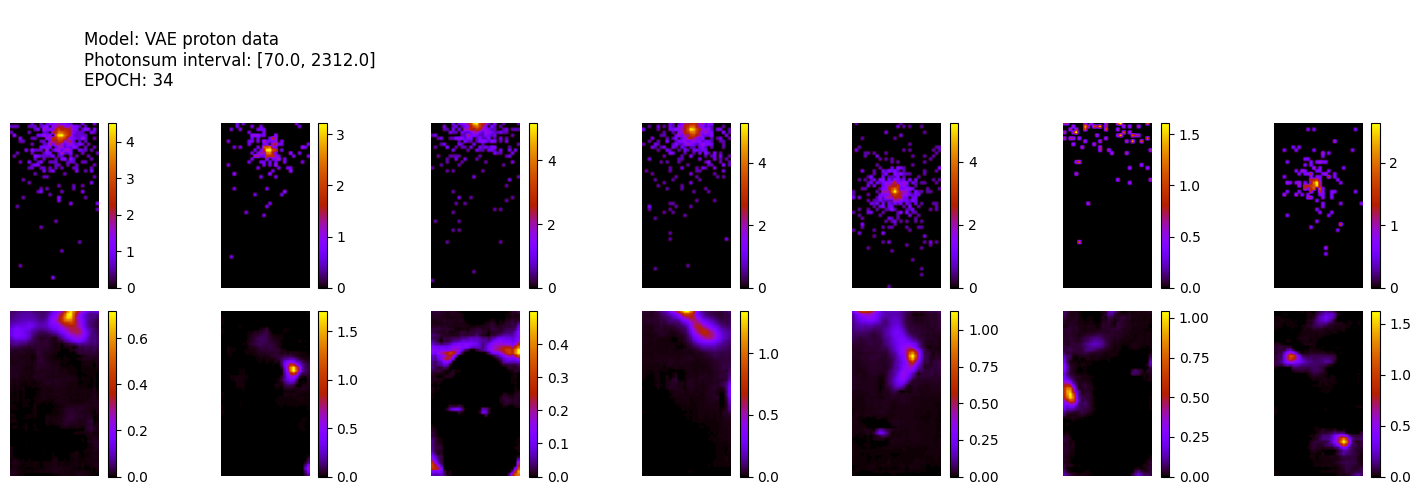

256/256 [==============================] - 1s 4ms/step
ws mean 114.40 ch1 0.13 ch2 90.56 ch3 0.75 ch4 194.79 ch5 285.77 Time for epoch 34 is 24.70582389831543 sec
8800 [Total loss: 86.34] [Recon_loss: 86.34] [KL loss: 0.00]
8900 [Total loss: 90.62] [Recon_loss: 90.62] [KL loss: 0.00]


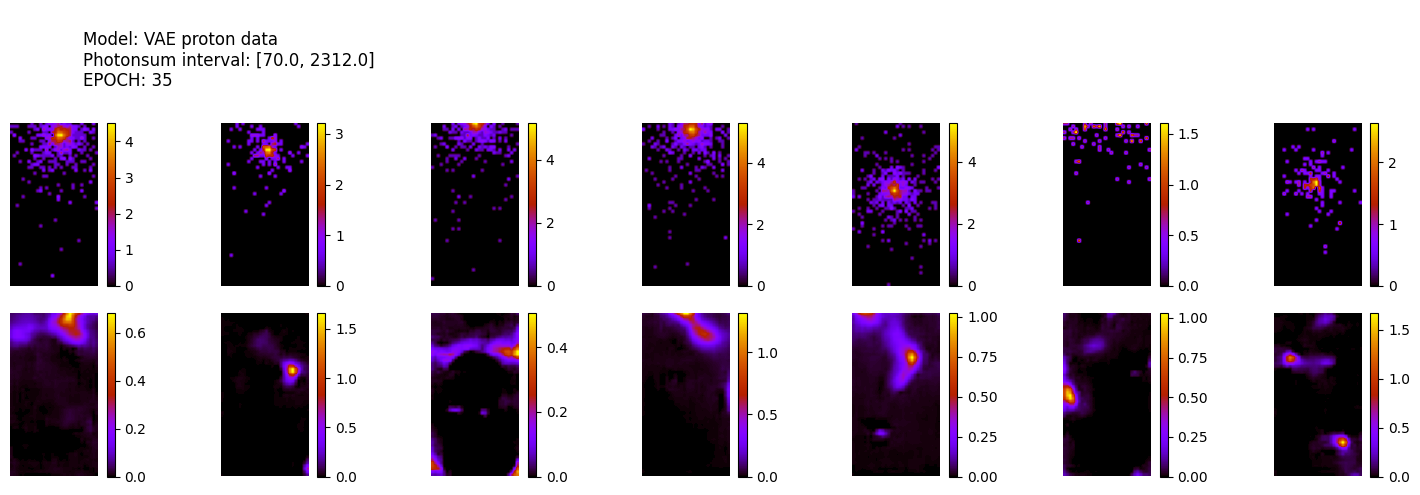

256/256 [==============================] - 1s 4ms/step
ws mean 114.01 ch1 0.13 ch2 90.26 ch3 0.75 ch4 194.10 ch5 284.79 Time for epoch 35 is 24.566871643066406 sec
9000 [Total loss: 85.40] [Recon_loss: 85.40] [KL loss: 0.00]


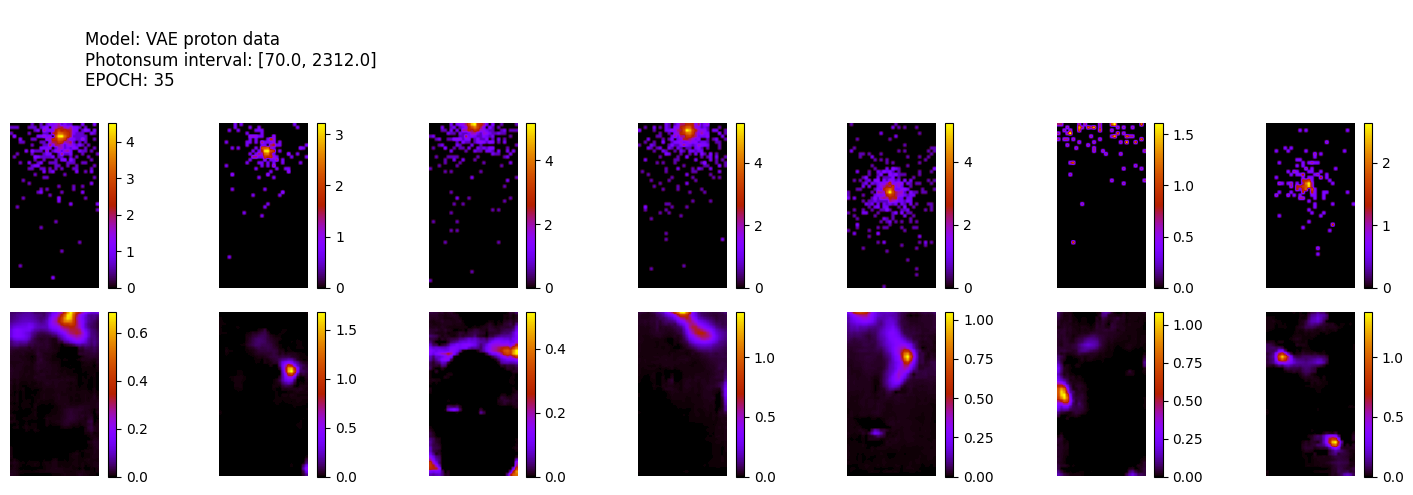

9100 [Total loss: 87.98] [Recon_loss: 87.98] [KL loss: 0.00]
9200 [Total loss: 83.44] [Recon_loss: 83.44] [KL loss: 0.00]


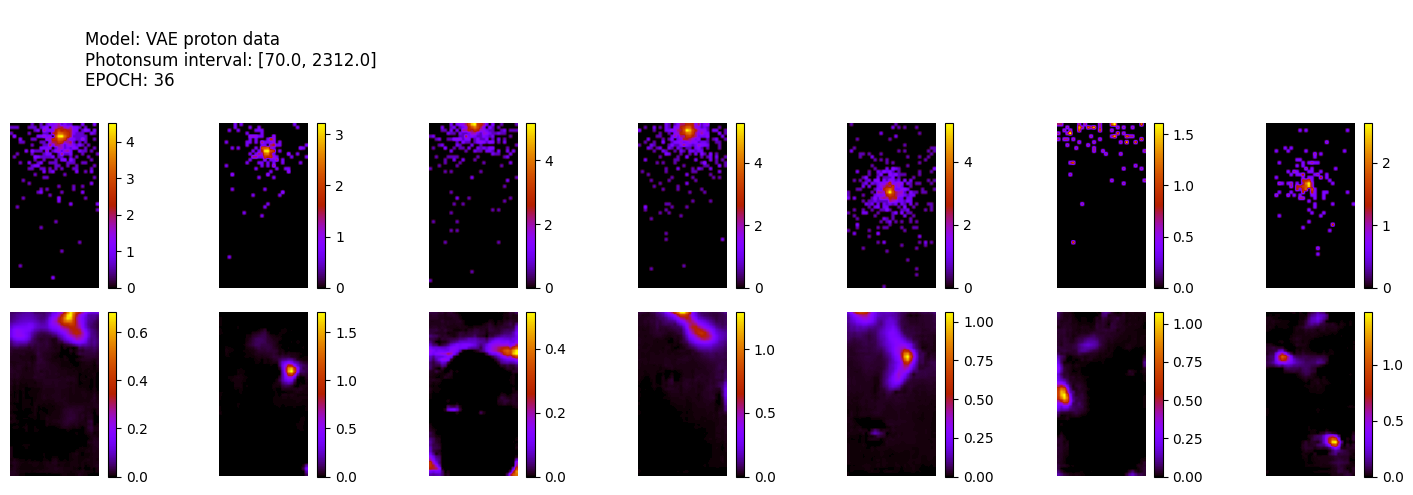

256/256 [==============================] - 1s 4ms/step
ws mean 114.85 ch1 0.12 ch2 91.78 ch3 0.75 ch4 194.70 ch5 286.90 Time for epoch 36 is 26.53272581100464 sec
9300 [Total loss: 82.90] [Recon_loss: 82.90] [KL loss: 0.00]
9400 [Total loss: 91.70] [Recon_loss: 91.70] [KL loss: 0.00]


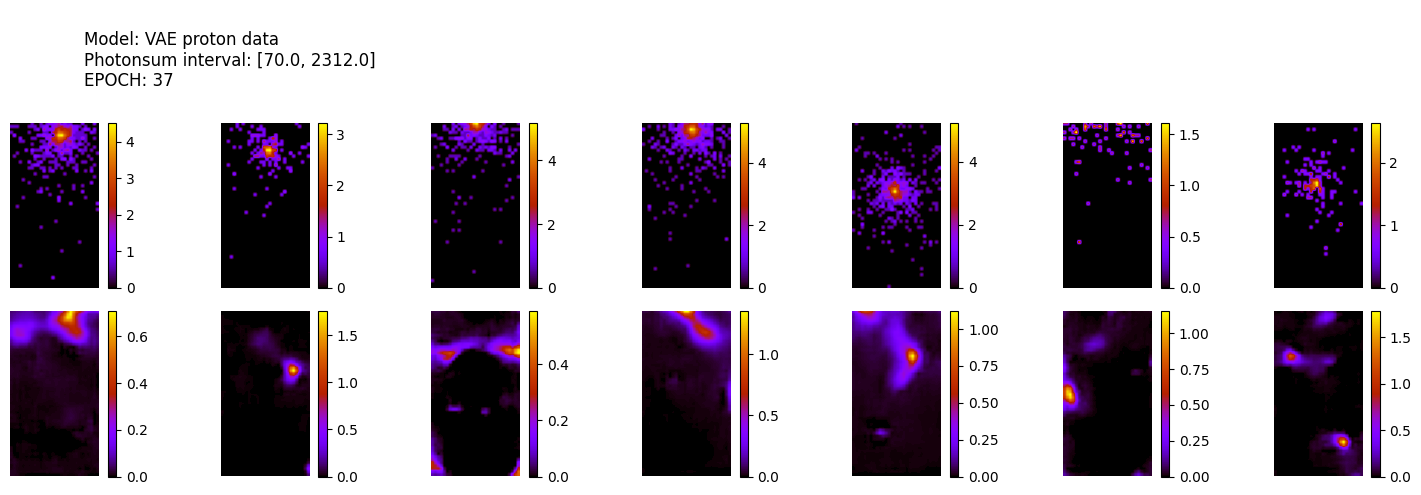

256/256 [==============================] - 1s 4ms/step
ws mean 112.23 ch1 0.12 ch2 87.56 ch3 0.74 ch4 192.39 ch5 280.35 Time for epoch 37 is 24.532381534576416 sec
9500 [Total loss: 86.04] [Recon_loss: 86.04] [KL loss: 0.00]
9600 [Total loss: 90.16] [Recon_loss: 90.16] [KL loss: 0.00]


KeyboardInterrupt: 

In [23]:
history=train(dataset_with_cond, EPOCHS)

## Visualize losses

In [24]:
import seaborn as sns

sns.set_context('notebook', font_scale=1)

In [25]:
# total_loss, reconstruction_loss, kl_loss
history_losses = np.array([[float(loss) for loss in losses] for losses in history])

In [26]:
total_loss = history_losses[:,0]
reconstruction_loss = history_losses[:,1]
kl_loss = history_losses[:,2]

In [29]:
a4_dims = (14, 5)
def print_loss(loss_values, loss_str):
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.lineplot(loss_values)
    plt.xscale('log')
    plt.yscale('log')
    ax.set_title(f"{loss_str} loss in each epoch")
    ax.set_xlabel("Epoch number")
    ax.set_ylabel(f"{loss_str} loss value")
    plt.savefig(os.path.join(filepath_img, f"{loss_str}_loss"))

/tmp/ipykernel_9919/1025777419.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


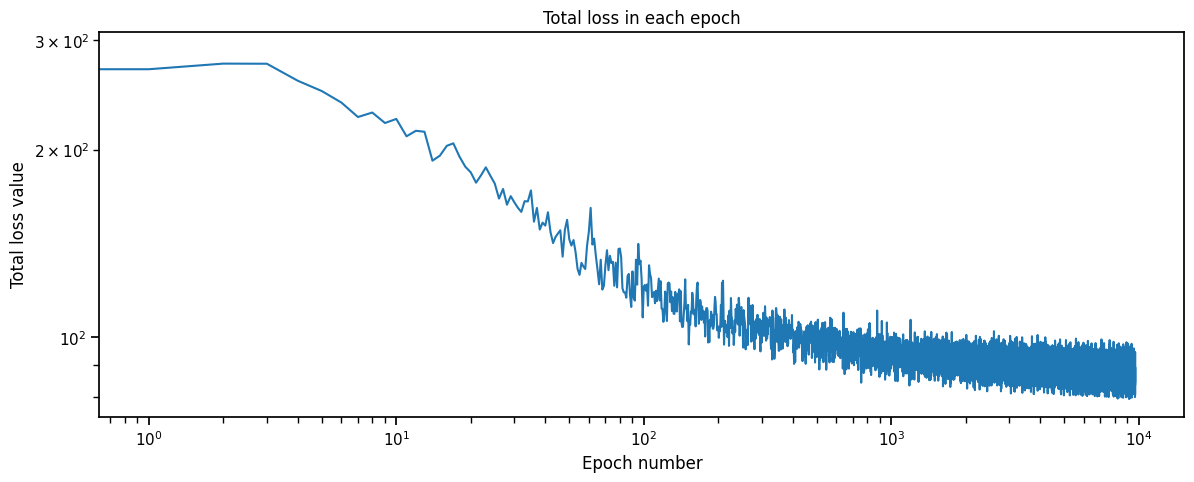

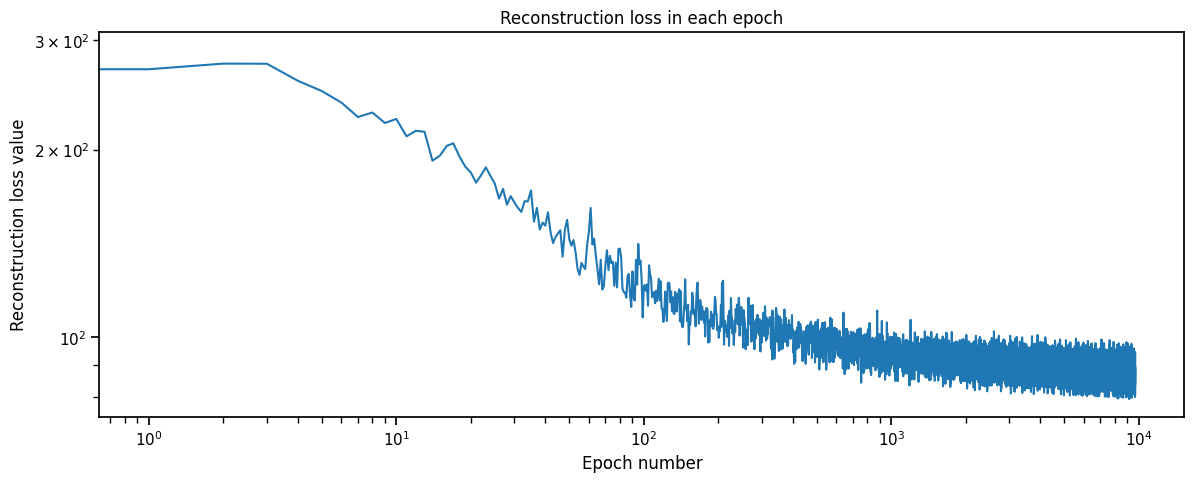

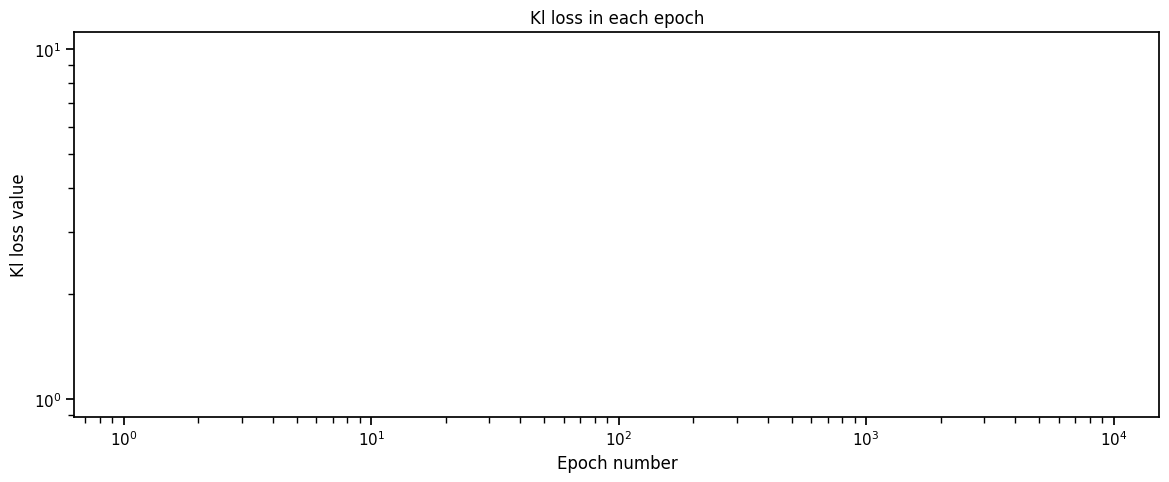

In [30]:
print_loss(total_loss, "Total")
print_loss(reconstruction_loss, "Reconstruction")
print_loss(kl_loss, "Kl")